In [1]:
import pandas as pd
import time
import numpy as np
import tensorflow as tf
import pickle
import glob
import gc
import sklearn
from DenseNet import DenseNet
from DEM import DEM
from sklearn.model_selection import KFold
import shutil
import os
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)
from sklearn import metrics, preprocessing, pipeline, \
    feature_extraction, decomposition, model_selection
import sklearn
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator
from tensorflow.python.keras import layers, preprocessing
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.callbacks import EarlyStopping, Callback
from tensorflow.python.keras.regularizers import l1, l2
from tensorflow.python.keras.optimizers import SGD, RMSprop, Adam, Nadam
from tensorflow.python.keras.losses import mean_squared_error, binary_crossentropy, categorical_crossentropy
from tensorflow.python.keras.applications import vgg16

# from keras.preprocessing import image
# from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator
# from keras import layers, preprocessing
# from keras import backend as K
# from keras.models import Model, load_model
# from keras.callbacks import EarlyStopping, Callback
# from keras.regularizers import l1, l2
# from keras.optimizers import SGD, RMSprop, Adam, Nadam
# from keras.losses import mean_squared_error, binary_crossentropy
# from keras.applications import vgg16
K.set_image_data_format('channels_last')

import numpy as np
# np.random.seed(seed = 100)
import json
import scipy 
import lightgbm as lgb

import gensim
import os
from gensim.models.word2vec import LineSentence
from gensim.models.fasttext import FastText as FT_gensim
from gensim.models.wrappers.fasttext import FastText as FT_wrapper

path = '../data/'

def read_image(imag_path, image_id):
    img = image.load_img(imag_path + image_id)
    img = image.img_to_array(img)
#     img= vgg16.preprocess_input(image.img_to_array(img))
    return img

In [2]:
# import keras
tf.__version__

'1.4.0'

In [28]:
# attr_list = pd.read_csv(path + '/DatasetA_train_20180813/attribute_list.txt', index_col = 0, sep = '\t', header = None)
# attr_list = attr_list.apply(lambda s: s[1].replace(' ', '_'), axis = 1)
# attributes_per_class = pd.read_csv(path + '/DatasetA_train_20180813/attributes_per_class.txt', 
#                                    index_col = 0, sep = '\t', header = None)
# adj_graph
# attr = np.array(list(class_id_emb_attr['attr']))
# adj_graph = sklearn.metrics.pairwise.pairwise_distances(attr, metric = 'l2')
# np.argsort(adj_graph[0])
# adj_graph
# class_id_emb_attr['attr'].values
with open(path + '../../zero-shot-gcn/data/imagenet_graph.pkl', 'rb') as handle:
    imagenet_graph = pickle.load(handle)
with open(path + '../../zero-shot-gcn/data/list/invdict_wordntext.json', 'r') as fp:
    words = json.load(fp)
class_names = class_id_emb_attr[class_id_emb_attr.class_id.isin(round2_class_id)]['class_name'].values
class_name_to_id = dict([(c, i) for i, c in enumerate(class_names)])
class_wns = [[]] * class_names.shape[0]
class_neighbor_wns = [[]] * class_names.shape[0]
words_array = np.asarray(words)
for i, word in enumerate(words):
    for w in word.split(', '):
        if w in class_name_to_id:
#             print (class_name_to_id[w], i)
            if len(class_wns[class_name_to_id[w]]) == 0:
                class_wns[class_name_to_id[w]] = []
            class_wns[class_name_to_id[w]].append(i)
#             print (class_wns)
            if len(class_neighbor_wns[class_name_to_id[w]]) == 0:
                class_neighbor_wns[class_name_to_id[w]] = []
            class_neighbor_wns[class_name_to_id[w]].extend(imagenet_graph[i])
#             print (word, words_array[imagenet_graph[i]])
#             print (i, w)
#             if w not in class_dict:
#                 class_dict[w] = 0
#             class_dict[w] += 1
# print (class_wns)
wn_to_class = dict()
for i, wns in enumerate(class_wns):
    for wn in wns:
        if wn not in wn_to_class:
            wn_to_class[wn] = []
        wn_to_class[wn].append(i)
        
adj_graph = scipy.eye(class_names.shape[0])
# for i, neighbor_wns in enumerate(class_neighbor_wns):
#     for j, wns in enumerate(class_wns):
#         if i == j:
#             continue
#         for neighbor in neighbor_wns:
#             if neighbor in wns:
#                 adj_graph[i, j] = 1
#                 adj_graph[j, i] = 1
# #                 print(class_names[i], class_names[j])
#                 break

def find_adj(root, current_wn, remain_depth):
    if current_wn in wn_to_class:
        for adj_class in wn_to_class[current_wn]:
            adj_graph[root][adj_class] = 1
            adj_graph[adj_class][root] = 1
    if remain_depth == 0:
        return
    for wn in imagenet_graph[current_wn]:
        find_adj(root, wn, remain_depth - 1)
        
for i, wns in enumerate(class_wns):
    for wn in wns:
        find_adj(i, wn, 2)
adj_graph

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [29]:
adj_graph.sum(axis = 1)

array([ 2.,  1.,  3.,  5.,  1.,  3.,  2.,  2.,  3., 19.,  1.,  2.,  2.,
        2., 19.,  5., 20., 19.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,
       22.,  3.,  1.,  1.,  2., 19.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,
        1.,  1., 22.,  2.,  1.,  1.,  2.,  1.,  1.,  1.,  3.,  1.,  2.,
        2.,  1.,  2.,  3.,  1.,  3.,  3.,  2.,  3.,  2.,  1.,  1., 19.,
        1.,  1.,  4.,  2.,  1.,  1.,  1.,  4.,  1.,  3.,  2.,  1.,  1.,
        3.,  1.,  1.,  1.,  2.,  1., 19.,  1.,  1.,  3.,  1.,  1.,  1.,
        1.,  4.,  2.,  2.,  2.,  1.,  7.,  1.,  1.,  4.,  2.,  1.,  1.,
        1.,  4.,  2.,  1.,  1., 19.,  2.,  1.,  1.,  1.,  1., 19.,  2.,
        2.,  2.,  2.,  1., 19.,  1.,  1.,  1.,  2.,  1.,  2.,  2., 23.,
        1.,  2.,  1.,  1.,  2.,  2.,  1.,  2., 22.,  1.,  7.,  1.,  2.,
        2.,  2.,  1.,  1.,  1.,  1.,  2.,  4.,  1.,  4.,  1.,  4.,  1.,
        2.,  2.,  3., 19.,  4.,  1.,  2.,  3.,  3.,  5.,  4., 19.,  2.,
        1.,  2.,  4.,  1., 19.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [9]:
# del setA_train_data, setB_train_data
# with open(path + 'setB_class_id_emb_attr.pickle', 'rb') as handle:
#     class_id_emb_attr = pickle.load(handle)
# with open(path + '/setA_train_data.pickle', 'rb') as handle:
#     setA_train_data = pickle.load(handle)
# with open(path + '/setB_train_data.pickle', 'rb') as handle:
#     setB_train_data = pickle.load(handle)
# with open(path + 'setB_test_data.pickle', 'rb') as handle:
#     test_data = pickle.load(handle)
    
# train_data = setA_train_data.append(setB_train_data)
# del setA_train_data, setB_train_data
# with open(path + '/model_sub/6_12_24_16_ini128_growth32_inistride1_augdata_05077/flat_train_re_2018_09_24_03_07_15.pickle', 'rb') as handle:
#     flat_train_re = pickle.load(handle)
# train_data['target'] = list(flat_train_re)
# with open(path + '/model_sub/6_12_24_16_ini128_growth32_inistride1_augdata_05077/flat_test_re_2018_09_24_03_07_15.pickle', 'rb') as handle:
#     flat_test_re = pickle.load(handle)
# test_data['target'] = list(flat_test_re)
# train_data.drop(columns = ['img_id'], inplace = True)

# with open(path + '/model_sub/6_12_24_16_ini64_growth32_inistride1_augdata_05010/train_data_2018_09_23_10_47_03.pickle', 'rb') as handle:
#     train_data = pickle.load(handle)
# with open(path + '/model_sub/6_12_24_16_ini64_growth32_inistride1_augdata_05010/test_data_2018_09_23_10_47_03.pickle', 'rb') as handle:
#     test_data = pickle.load(handle)
    
with open(path + 'round2_class_id_emb_attr_add_golve_crawl_42B.pkl', 'rb') as handle:
    class_id_emb_attr = pickle.load(handle)
    class_id_emb_attr['emb'] = class_id_emb_attr['emb_glove']
    class_id_emb_attr.drop(columns = ['emb_glove', 'emb_fasttext', 'emb_glove_crawl', 'emb_glove_crawl_42B'], inplace = True)
# del loaded_model
ft_files = [
#             path + '/skipgram_100_5Epoch/',
#             path + '/skipgram_200_5Epoch/',
# #             path + 'skipgram_300_5Epoch/',
# #             path + 'skipgram_300_5Epoch_24Thread/',
#             path + 'skipgram_100_10Epoch/',
            path + 'skipgram_300_10Epoch/',
# #             path + 'cbow_300_10Epoch/',
#             path + 'skipgram_100_10Epoch_NewNorm/',
            path + 'LatestCorpus_skipgram_100_5Epoch/',
            path + 'skipgram_300_10Epoch_NewNorm/',
            path + 'skipgram_100_10Epoch_NewNorm/'
#            path + 'documents_utf8_filtered_20pageviews_rmurl_lower_norm_skipgram/ft',
           ]
for ft_dir in ft_files:
    loaded_model = FT_wrapper.load(ft_dir + '/ft')
    class_id_emb_attr['FT'] = class_id_emb_attr['class_name'].apply(lambda c: loaded_model[c]).apply(lambda s: ' '.join(str(f) for f in s))
    ft_prefix = ft_dir.split('/')[-2]
    class_id_emb_attr[['class_name', 'FT']].to_csv(path + 'ft_class_embs/' + ft_prefix, index = False)
    del loaded_model
#     class_id_emb_attr['emb'] = class_id_emb_attr.apply(lambda s: np.hstack([s['emb'], s['FT']]), axis = 1)

In [4]:
with open(path + '/round1_train_img_part0.pkl', 'rb') as handle:
    round1_train_img_part0 = pickle.load(handle)
with open(path + '/round1_train_img_part1.pkl', 'rb') as handle:
    round1_train_img_part1 = pickle.load(handle)
with open(path + '/round2_train_img.pkl', 'rb') as handle:
    round2_train_img = pickle.load(handle)
# with open(path + '/round2B_train_img.pkl', 'rb') as handle:
#     round2B_train_img = pickle.load(handle)
with open(path + '/round2_test_img.pkl', 'rb') as handle:
        test_data = pickle.load(handle)
train_data = pd.concat([round1_train_img_part0, round1_train_img_part1, 
                        round2_train_img, 
#                         round2B_train_img
                       ], axis = 0, sort = False)

In [5]:
with open(path + '/model_sub/6_12_24_16_ini128_growth32_inistride1_augdata_05108_TF14_DensetNetProcess/train_data_img_flat_20181015_113824.pickle', 'rb') as handle:
    train_img_flat = pickle.load(handle)
with open(path + '/model_sub/6_12_24_16_ini128_growth32_inistride1_augdata_05108_TF14_DensetNetProcess/test_data_img_flat_20181015_113824.pickle', 'rb') as handle:
    test_img_flat = pickle.load(handle)
round2_class_id = ['ZJL' + str(i) for i in range(296, 501)]
round2_train_class_id = round2_train_img.class_id.unique()
del round1_train_img_part0, round1_train_img_part1, round2_train_img
gc.collect()
train_data = train_data.merge(class_id_emb_attr, how = 'left', on = 'class_id')
train_data['target'] = list(train_img_flat)
test_data['target'] = list(test_img_flat)

In [ ]:
# del loaded_model
loaded_model = FT_wrapper.load(path + '/documents_utf8_filtered_20pageviews_rmurl_1e5_5Epoch/documents_utf8_filtered_20pageviews_rmurl_1e5_5Epoch.wv')
class_id_emb_attr['FT'] = class_id_emb_attr['class_name'].apply(lambda c: loaded_model[c])
del loaded_model

class_id_emb_attr['emb'] = class_id_emb_attr.apply(lambda s: np.hstack([s['emb'][:300], s['FT']]), axis = 1)

In [30]:
def read_class_emb(class_emb_path):
    class_emb = pd.read_csv(class_emb_path, index_col = 0, sep = ' ', header = None)
    class_emb.index.name = 'class_name'
    class_emb = class_emb.apply(lambda s: np.array([float(x) for x in s])[:300], axis = 1)
    return class_emb

glove_emb = read_class_emb(path + '/semifinal_image_phase2/class_wordembeddings.txt')
# fasttext_emb =  read_class_emb(path + '/External/class_wordembeddings_fasttext')

class_id_to_name = pd.read_csv(path + '/semifinal_image_phase2/label_list.txt', 
                            index_col = 'class_name', sep = '\t', header = None, names = ['class_id', 'class_name'])

attr_list = pd.read_csv(path + '/semifinal_image_phase2/attribute_list.txt', index_col = 0, sep = '\t', header = None)

attributes_per_class = pd.read_csv(path + '/semifinal_image_phase2/attributes_per_class.txt', 
                                index_col = 0, sep = '\t', header = None)
attributes_per_class.index.name = 'class_id'
attributes_per_class = attributes_per_class.apply(lambda s: np.array([float(x) for x in s]), axis = 1)

round2B_class_id_emb_attr = class_id_to_name.copy()
round2B_class_id_emb_attr['emb'] = glove_emb
# class_id_emb_attr['emb_fasttext'] = fasttext_emb
# class_id_emb_attr['emb'] = class_id_emb_attr.apply(lambda s: np.hstack([s['emb_glove'], s['emb_fasttext']]), axis = 1)
round2B_class_id_emb_attr.reset_index(inplace = True)
round2B_class_id_emb_attr.set_index('class_id', inplace = True)
round2B_class_id_emb_attr['attr'] = attributes_per_class
round2B_class_id_emb_attr.reset_index(inplace = True)
# print ('Load class_id_emb_attr Done')

In [31]:
round2_class_id = ['ZJL' + str(i) for i in range(296, 501)]
round2B_class_id_emb_attr = pd.concat([class_id_emb_attr[~class_id_emb_attr.class_id.isin(round2_class_id)], round2B_class_id_emb_attr])
with open(path + 'round2B_class_id_emb_attr.pkl', 'wb') as handle:
    pickle.dump(round2B_class_id_emb_attr, handle)

In [23]:
len(set(round2B_train_img.img_id) - set(round2_train_img.img_id))
# round2B_train_img.shape

31979

In [2]:
def read_image_data(img_id_path, imag_path, cols, debug):
    img_data = pd.read_csv(img_id_path, sep = '\t', header = None, names = cols)
    if debug:
        img_data = img_data[:2000]
    img_data['img'] = img_data['img_id'].progress_apply(lambda id: 
                            image.img_to_array(image.load_img(imag_path + id, target_size = (72, 72, 3))))
    return img_data

print ('Load setA_train_data ----')
setA_train_data = read_image_data(img_id_path = path + '/DatasetA/train.txt', imag_path = path + '/DatasetA/train/', 
            cols = ['img_id', 'class_id'], debug = False)
print ('Load setB_train_data ----')
setB_train_data = read_image_data(img_id_path = path + '/DatasetB/train.txt', imag_path = path + '/DatasetB/train/', 
            cols = ['img_id', 'class_id'], debug = False)
                                  
round2A_train_data = read_image_data(img_id_path = path + '/round2_DatasetA_20180927/train.txt', 
                                  imag_path = path + '/round2_DatasetA_20180927/train/', 
            cols = ['img_id', 'class_id'], debug = False)

round2B_train_data = read_image_data(img_id_path = path + '/semifinal_image_phase2/train.txt', 
                                  imag_path = path + '/semifinal_image_phase2/train/', 
            cols = ['img_id', 'class_id'], debug = False)
# print ('Load setB_train_data ----')
# setB_train_data = read_image_data(img_id_path = path + '/DatasetB/train.txt', imag_path = path + '/DatasetB/train/', 
#             cols = ['img_id', 'class_id'], debug = FLAGS.debug)
# train_data = setA_train_data.append(setB_train_data)
# del setA_train_data, setB_train_data
# train_data = train_data.merge(class_id_emb_attr, how = 'left', on = 'class_id')

print ('Load test_data ----')
test_data = read_image_data(img_id_path = path + '/semifinal_image_phase2/image.txt', 
                            imag_path = path + '/semifinal_image_phase2/test/', 
            cols = ['img_id'], debug = False)

  0%|          | 83/38221 [00:00<00:46, 824.75it/s]

Load setA_train_data ----


  0%|          | 104/49028 [00:00<00:47, 1039.66it/s]

Load setB_train_data ----


  0%|          | 20/8024 [00:00<00:42, 190.38it/s]

Load test_data ----


100%|██████████| 8024/8024 [00:59<00:00, 135.04it/s]


In [4]:
with open(path + 'pix72/round1A_train_img.pkl', 'wb') as handle:
    pickle.dump(setA_train_data, handle)
with open(path + 'pix72/round1B_train_img.pkl', 'wb') as handle:
    pickle.dump(setB_train_data, handle)
with open(path + 'pix72/round2A_train_img.pkl', 'wb') as handle:
    pickle.dump(round2A_train_data, handle)
with open(path + 'pix72/round2B_train_data.pkl', 'wb') as handle:
    pickle.dump(round2B_train_data, handle)
with open(path + 'pix72/round2B_test_data.pkl', 'wb') as handle:
    pickle.dump(test_data, handle)

In [5]:
fast_text =  pd.read_csv(path + '/External/class_wordembeddings_glove', 
                        index_col = 0, sep = ' ', header = None)
fast_text.index.name = 'class_name'
fast_text_df = pd.DataFrame(index = fast_text.index)
fast_text_df['emb_glove_crawl'] = fast_text.apply(lambda s: np.array([float(x) for x in s])[:300], axis = 1)

train_data = train_data.merge(fast_text_df, how = 'left', on = 'class_name')

# train_data['emb'] = train_data.apply(lambda s: np.hstack([s['emb'], s['emb_glove_crawl']]), axis = 1)

class_id_emb_attr = class_id_emb_attr.merge(fast_text_df, how = 'left', on = 'class_name')
class_id_emb_attr['emb'] = class_id_emb_attr.apply(lambda s: np.hstack([s['emb'], s['emb_glove_crawl']]), axis = 1)

In [4]:
with open(path + 'round2_class_id_emb_attr_add_golve_crawl.pkl', 'wb') as handle:
    pickle.dump(class_id_emb_attr, handle)

In [3]:
class DenseNet:
    """
    """
    def __init__(self, scores = None, cat_max = None, flags = None, model_type = None):
        self.batch_size = 128 #flags.densenet_batch_size
        self.epochs = 200 #flags.densenet_epochs
        self.patience = 30 #flags.densenet_patience
        self.scores = scores
        self.cat_max = cat_max
        self.model_type = model_type
        self.aug_data = True #flags.aug_data
        self.lr = 1e-3 #flags.lr
        self.verbose = 2 #flags.train_verbose
        self.OneHotEncoder = sklearn.preprocessing.OneHotEncoder()
        self.model = self.small_densenet(
                blocks = [6, 12, 24, 16], #[int(b.strip()) for b in flags.blocks.strip().split(',')], 
                weight_decay = 1e-4, #flags.weight_decay, 
                kernel_initializer = 'he_normal', #flags.kernel_initializer,
                init_filters = 128, #flags.init_filters,
                reduction = 0.5, #flags.reduction,
                growth_rate = 32, #flags.growth_rate,
                init_stride = 1 #flags.init_stride
                )

    def dense_block(self, x, blocks, name, 
            weight_decay = 1e-4, 
            kernel_initializer = 'he_normal',
            growth_rate = None):
        """A dense block.
        # Arguments
            x: input tensor.
            blocks: integer, the number of building blocks.
            name: string, block label.
        # Returns
            output tensor for the block.
        """
        for i in range(blocks):
            x = self.conv_block(x, growth_rate, name=name + '_block' + str(i + 1), 
                weight_decay = weight_decay,
                kernel_initializer = kernel_initializer)
        return x

    def transition_block(self, x, reduction, name, weight_decay = 1e-4, kernel_initializer = 'he_normal'):
        """A transition block.
        # Arguments
            x: input tensor.
            reduction: float, compression rate at transition layers.
            name: string, block label.
        # Returns
            output tensor for the block.
        """
        bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                    name=name + '_bn')(x)
        x = layers.Activation('relu', name=name + '_relu')(x)
        x = layers.Conv2D(int(K.int_shape(x)[bn_axis] * reduction), 1,
                        use_bias=False,
                        kernel_initializer = kernel_initializer,
                        kernel_regularizer = l2(weight_decay),
                        name=name + '_conv')(x)
        x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
        return x

    def conv_block(self, x, growth_rate, name, weight_decay = 1e-4, kernel_initializer = 'he_normal'):
        """A building block for a dense block.
        # Arguments
            x: input tensor.
            growth_rate: float, growth rate at dense layers.
            name: string, block label.
        # Returns
            Output tensor for the block.
        """
        bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
        x1 = layers.BatchNormalization(axis=bn_axis,
                                    epsilon=1.001e-5,
                                    name=name + '_0_bn')(x)
        x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
        x1 = layers.Conv2D(4 * growth_rate, 1,
                        use_bias=False,
                        kernel_initializer = kernel_initializer,
                        kernel_regularizer = l2(weight_decay),
                        name=name + '_1_conv')(x1)
        x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                    name=name + '_1_bn')(x1)
        x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
        x1 = layers.Conv2D(growth_rate, 3,
                        padding='same',
                        use_bias=False,
                        kernel_initializer = kernel_initializer,
                        kernel_regularizer = l2(weight_decay),
                        name=name + '_2_conv')(x1)
        x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
        return x

    def small_densenet(self, img_input_shape = (64, 64, 3), 
        blocks = [6, 12, 24, 16], 
        weight_decay = 1e-4, 
        kernel_initializer = 'he_normal',
        init_filters = None,
        reduction = None,
        growth_rate = None,
        init_stride = None
        ):
        img_input = layers.Input(shape = (img_input_shape))

        x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
        x = layers.Conv2D(init_filters, 3, strides=init_stride, use_bias=False, 
            kernel_initializer = kernel_initializer, 
            kernel_regularizer = l2(weight_decay),
            name='conv1/conv')(x)
        x = layers.BatchNormalization(
            axis=3, epsilon=1.001e-5, name='conv1/bn')(x)
        x = layers.Activation('relu', name='conv1/relu')(x)
        x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
        x = layers.AveragePooling2D(3, strides=2, name='pool1')(x)
        
        for i, block in enumerate(blocks):
            scope_num_str = str(i + 2)
            x = self.dense_block(x, block, name='conv' + scope_num_str, 
                                 growth_rate = growth_rate,
                                 weight_decay = weight_decay, 
                                 kernel_initializer = kernel_initializer)
            if i != len(blocks) - 1:
                x = self.transition_block(x, reduction, name='pool' + scope_num_str, 
                                          weight_decay = weight_decay, kernel_initializer = kernel_initializer)
        x = layers.BatchNormalization(
            axis=3, epsilon=1.001e-5, name='bn')(x)
        x = layers.Activation('relu', name='relu')(x)

        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(self.cat_max, activation='softmax',
            kernel_initializer = kernel_initializer, 
            name='fc')(x)
        
        model = Model(img_input, x)
        model.compile(optimizer = Adam(lr=self.lr), loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        
        return model

    def DNN_DataSet(self, df):
        """
        """
        return preprocess_img(df['img'])

    def train(self, train_part_df, train_part_label, validate_part_df, validate_part_label):
        """
        Keras Training
        """
        print("-----DNN training-----")

        DNN_Train_Data = self.DNN_DataSet(train_part_df)
        DNN_validate_Data = self.DNN_DataSet(validate_part_df)

        callbacks = [
                EarlyStopping(monitor='val_categorical_accuracy', patience=self.patience, verbose=0),
                ]
        if self.aug_data:
            datagen = preprocessing.image.ImageDataGenerator(
                    rotation_range=45,
                    shear_range = 0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)

            datagen.fit(DNN_Train_Data)

            h = self.model.fit_generator(datagen.flow(DNN_Train_Data, train_part_label, batch_size=self.batch_size), 
                    validation_data=(DNN_validate_Data, validate_part_label), steps_per_epoch = DNN_Train_Data.shape[0]//self.batch_size,
                    epochs=self.epochs, shuffle=True, verbose = self.verbose, workers=1, use_multiprocessing=False, 
                    callbacks=callbacks)
        else:
            h = self.model.fit(DNN_Train_Data, train_part_label, batch_size=self.batch_size, epochs=self.epochs,
                        shuffle=True, verbose=self.verbose,
                        validation_data=(DNN_validate_Data, validate_part_label)
                        , callbacks=callbacks
                        )
        self.scores.append(pd.DataFrame(h.history))
        return self.model

    def predict(self, test_part, batch_size = 1024, verbose=2):
        """
        Keras Training
        """
        print("-----DNN Test-----")
        pred = self.model.predict(self.DNN_DataSet(test_part), verbose=verbose)
        return pred

In [8]:
img_model = DenseNet(scores = None, 
                     cat_max = 205, #flags.cat_max, 
                     flags = None, 
                     model_type = 'DenseNet').model
# model_file_name = glob.glob(model_path + '/imgmodel_*.h5')[0]
# print ('Model file name: ', model_file_name)
# img_model.load_weights(model_file_name)
img_model.load_weights('../../Data/model_sub/6_12_24_16_ini128_growth32_inistride1_augdata_05077/model_0_2018_09_24_03_07_15.h5')
# img_model_flat = Model(input = img_model.input, output = img_model.get_layer(name = 'avg_pool').output)
train_data['target'] = list(model_eval(img_model, 'DenseNet', train_data))
test_data['target'] = list(model_eval(img_model, 'DenseNet', test_data))

7817/7817 [==============================] - 817s   


In [52]:
x = np.random.randint(1, 10, (3, 3))
x

array([[4, 5, 7],
       [2, 8, 6],
       [7, 6, 4]])

In [53]:
np.random.choice(x, 2)

ValueError: a must be 1-dimensional

In [16]:
205 * 205

42025

In [6]:
import threading

def extract_array_from_series(s):
    return np.asarray(list(s))

def create_dem_data(df, only_emb = False, emb_len = 1200):
    if only_emb:
        emb = extract_array_from_series(df['emb'])[:, -300:]
        attr = np.zeros((emb.shape[0], 50))
        return [attr, emb]
    else:
        return [extract_array_from_series(df['attr'])[:, :50], extract_array_from_series(df['emb'])[:, -100:]]

def create_gcn_data(df, class_to_id):
    return np.array([class_to_id[c] for c in df['class_id'].values]).astype('int32')

def create_qfsl_data(df, class_to_id, categories = 205):
    OneHotEncoder = sklearn.preprocessing.OneHotEncoder(n_values = categories )
    train_target = df['class_id'].apply(lambda c: class_to_id[c]).values
    train_target = OneHotEncoder.fit_transform(np.reshape(train_target, (-1, 1))).toarray()
    return [extract_array_from_series(df['target']), train_target]

def neg_aug_data(pos_data, train_class_id, class_id_emb_attr = None, c2c_neg_cnt = None, only_emb = False):
    if c2c_neg_cnt is None:
        pos_len = pos_data[0].shape[0]
        ind_array = np.array(range(pos_len))
    #     rs = np.random.RandomState(seed=420)
    #     perm_ind_array = rs.permutation(rs.permutation(rs.permutation(rs.permutation(ind_array))))
        perm_ind_array = np.random.permutation(ind_array)
        perm_label = np.zeros(pos_len)
        perm_label[train_class_id == train_class_id[perm_ind_array]] = 1
        perm_img_feature_map = pos_data[0][perm_ind_array] 

        neg_data = [perm_img_feature_map] + pos_data[1:3] + [perm_label]
    else:
        train_class_id_uniq = np.unique(train_class_id)
        attr_embs = create_dem_data(class_id_emb_attr, only_emb)
        neg_attrs = []
        neg_embs = []
        neg_imgs = []
        img_origin_ind = np.array(range(train_class_id.shape[0]))
        for i, class_id in enumerate(list(class_id_emb_attr.class_id)):
            per_class_attrs,  per_class_embs = attr_embs[0][i], attr_embs[1][i]
            per_class_neg_imgs = []
            for have_img_clas_id in train_class_id_uniq:
                if class_id == have_img_clas_id:
                    continue
                imgs_ind = img_origin_ind[train_class_id == have_img_clas_id]
                per_class_neg_imgs.extend(list(pos_data[0][np.random.choice(imgs_ind, c2c_neg_cnt)]))
            per_class_neg_len = len(per_class_neg_imgs)
#             print ('Class_id, neg', class_id, per_class_neg_len)
            neg_attrs.extend([per_class_attrs] * per_class_neg_len)
            neg_embs.extend([per_class_embs] * per_class_neg_len)
            neg_imgs.extend(per_class_neg_imgs)
        neg_data = [np.array(neg_imgs), np.array(neg_attrs), np.array(neg_embs), np.zeros(len(neg_imgs))]
    return neg_data
        
def create_dem_bc_data(df, neg_aug = 0, only_emb = False, class_id_emb_attr = None, c2c_neg_cnt = None):
    """
    """
    train_data = [extract_array_from_series(df['target'])] + create_dem_data(df, only_emb)
    train_len = train_data[0].shape[0]
    train_data = train_data + [np.ones(train_len)]
    merge_data = train_data
    if neg_aug > 0:
        train_class_id = extract_array_from_series(df['class_id'])
        for i in range(neg_aug):
            neg_data = neg_aug_data(train_data, train_class_id, 
                                    class_id_emb_attr = class_id_emb_attr, 
                                    c2c_neg_cnt = c2c_neg_cnt,
                                    only_emb = only_emb)
            merge_data = [np.r_[merge_data[i], neg_data[i]] for i in range(len(merge_data))]
        print ('DEM BC Data Train Len, Pos, Neg:', train_len, np.sum(merge_data[-1]), np.sum(merge_data[-1] == 0))
        return merge_data
    else:
        return train_data
            
def preprocess_numpy_input(x, data_format = 'channels_last', mode = 'torch', **kwargs):
    """Preprocesses a Numpy array encoding a batch of images.

    # Arguments
        x: Input array, 3D or 4D.
        data_format: Data format of the image array.
        mode: One of "caffe", "tf" or "torch".
            - caffe: will convert the images from RGB to BGR,
                then will zero-center each color channel with
                respect to the ImageNet dataset,
                without scaling.
            - tf: will scale pixels between -1 and 1,
                sample-wise.
            - torch: will scale pixels between 0 and 1 and then
                will normalize each channel with respect to the
                ImageNet dataset.

    # Returns
        Preprocessed Numpy array.
    """
    if not issubclass(x.dtype.type, np.floating):
        x = x.astype(K.floatx(), copy=False)

    if mode == 'tf':
        x /= 127.5
        x -= 1.
        return x

    if mode == 'torch':
        x /= 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        if data_format == 'channels_first':
            # 'RGB'->'BGR'
            if x.ndim == 3:
                x = x[::-1, ...]
            else:
                x = x[:, ::-1, ...]
        else:
            # 'RGB'->'BGR'
            x = x[..., ::-1]
        mean = [103.939, 116.779, 123.68]
        std = None

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] -= mean[0]
            x[1, :, :] -= mean[1]
            x[2, :, :] -= mean[2]
            if std is not None:
                x[0, :, :] /= std[0]
                x[1, :, :] /= std[1]
                x[2, :, :] /= std[2]
        else:
            x[:, 0, :, :] -= mean[0]
            x[:, 1, :, :] -= mean[1]
            x[:, 2, :, :] -= mean[2]
            if std is not None:
                x[:, 0, :, :] /= std[0]
                x[:, 1, :, :] /= std[1]
                x[:, 2, :, :] /= std[2]
    else:
        x[..., 0] -= mean[0]
        x[..., 1] -= mean[1]
        x[..., 2] -= mean[2]
        if std is not None:
            x[..., 0] /= std[0]
            x[..., 1] /= std[1]
            x[..., 2] /= std[2]
    return x

def preprocess_img(img_series):
    return preprocess_numpy_input(extract_array_from_series(img_series))

def multi_labels_cross_entropy(y_true, y_preds, eps = 1e-6):
#     multi_labels_loss = [sklearn.metrics.log_loss]
#     y_preds_clip = max(eps, min(1 - eps, y_preds))
    y_preds_clip = np.clip(y_preds, eps, 1- eps)
    multi_loss = -(y_true * np.log(y_preds_clip) + (1 - y_true) * np.log(1 - y_preds_clip))
    return np.mean(multi_loss, axis = -1)

def find_nearest_class(class_id_emb_attr, eval_df, cand_feature_map = None, img_feature_map = None,
                      model_type = None, attr_preds = None, zs_model = None, dis_arr = None):
    nearest_class_id = ['ZJL'] * img_feature_map.shape[0]
    for i in range(img_feature_map.shape[0]):
        if model_type == 'I2A':
            dis = multi_labels_cross_entropy(extract_array_from_series(class_id_emb_attr['attr'])[:, :50],
                                            attr_preds[i])
        elif model_type == 'DEM_BC':
            img = img_feature_map[i]
            pred_data = cand_feature_map * img
            dis = 1 - zs_model.predict(pred_data)
        elif model_type == 'lgb':
            img = img_feature_map[i]
            pred_data = cand_feature_map * img
            dis = 1 - zs_model.predict(pred_data, num_iteration = -1)
        elif model_type == 'QFSL':
            dis = 1 - dis_arr[i]
        else:
            img = img_feature_map[i]
            dis = np.linalg.norm(img - cand_feature_map, axis = 1)
        min_ind = np.where(dis == np.amin(dis))[0]
        nearest_class_id[i] = class_id_emb_attr.iloc[min_ind[0]]['class_id']
    return np.asarray(nearest_class_id)
        
def calc_accuracy(eval_df, eval_class, preds):
    eval_mask = eval_df.class_id.isin(eval_class)
    eval_num = np.sum(eval_mask)
    right_num = np.sum(preds[eval_mask] == eval_df.class_id[eval_mask])
    return right_num / np.sum(eval_mask), right_num, eval_num
    
def calc_detailed_accuracy(eval_df, preds, class_id_dict):
    print ("\n")
    for class_set_name in sorted(class_id_dict):
        class_set = class_id_dict[class_set_name]
        re = calc_accuracy(eval_df, class_set, preds)
        print("%s: \t%.6f\t%.0f\t%.0f" % ((class_set_name,) + re))
#     print ("\n")

def multi_preds_vote(preds):
    vote_preds = []
    for single_img_vote in preds:
        uniq_val, counts = np.unique(single_img_vote, return_counts = True)
        vote_preds.append(uniq_val[np.argmax(counts)])
    vote_preds = np.asarray(vote_preds)
    return vote_preds
    
def multi_models_vote(models, eval_df = None, cand_class_id_emb_attr = None, img_feature_map = None, 
                      class_id_dict = None):
    print ('cand shape: ', cand_class_id_emb_attr.shape[0])
    preds = models_eval(models, eval_df, cand_class_id_emb_attr, img_feature_map, 
                class_id_dict)
    preds = np.asarray(preds).T
    vote_preds = multi_preds_vote(preds)
    # print (vote_preds)
    print ('Multi model votes results:')
    if 'class_id' in eval_df.columns: 
        calc_detailed_accuracy(eval_df, vote_preds, class_id_dict)
    return vote_preds

def model_eval(model, model_type, eval_df, cand_class_id_emb_attr = None, img_feature_map = None, 
                class_id_dict = None, class_to_id = None, TTA = None, img_model = None, only_emb = None):
    """
    """
    if model_type == 'DenseNet':
        flat_model = Model(inputs = model.inputs, outputs = model.get_layer(name = 'avg_pool').output)
        pred = flat_model.predict(preprocess_img(eval_df['img']), verbose = 1)
    elif model_type == 'DEM' or model_type == 'AE':
        zs_model = Model(inputs = model.inputs[:2], outputs = model.outputs[0])
        cand_feature_map = zs_model.predict(create_dem_data(cand_class_id_emb_attr), verbose = 2)
        if TTA is not None:
            batch_size = 32
            datagen = MixedImageDataGenerator(
                    rotation_range=20,
                    shear_range = 0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)
            img_feature_map = img_model.predict_generator(
                datagen.flow((preprocess_img(eval_df['img'])), None, shuffle = False, batch_size = batch_size), 
                steps = np.ceil(eval_df.shape[0] / batch_size) * TTA, verbose = 1)
            pred = find_nearest_class(cand_class_id_emb_attr, eval_df, cand_feature_map, img_feature_map)
            pred = np.reshape(pred, (TTA, eval_df.shape[0])).T
            pred = multi_preds_vote(pred)
        else:
            pred = find_nearest_class(cand_class_id_emb_attr, eval_df, cand_feature_map, img_feature_map)
        if 'class_id' in eval_df.columns:
            calc_detailed_accuracy(eval_df, pred, class_id_dict)
    elif model_type == 'DEM_BC':
        zs_model = Model(inputs = model.inputs[1:3], outputs = model.outputs[0])
        cand_feature_map = zs_model.predict(create_dem_data(cand_class_id_emb_attr, only_emb = only_emb), verbose = 1)
        zs_model = Model(inputs = model.get_layer('attr_x_img_model').inputs, 
                         outputs = model.get_layer('attr_x_img_model').outputs)
        pred = find_nearest_class(cand_class_id_emb_attr, eval_df, cand_feature_map = cand_feature_map, img_feature_map = img_feature_map,
                                zs_model = zs_model, model_type = model_type)
        if 'class_id' in eval_df.columns:
            calc_detailed_accuracy(eval_df, pred, class_id_dict)
    elif model_type == 'GCN':
        zs_model = Model(inputs = model.inputs[2:], outputs = model.outputs[0])
        cand_class_to_id = [class_to_id[c] for c in cand_class_id_emb_attr.class_id.values]
        cand_feature_map = zs_model.predict(None, steps = 1)[cand_class_to_id]
        pred = find_nearest_class(cand_class_id_emb_attr, eval_df, cand_feature_map, img_feature_map)
        if 'class_id' in eval_df.columns:
            calc_detailed_accuracy(eval_df, pred, class_id_dict)
    elif model_type == 'QFSL':
        cand_class_to_id = [class_to_id[c] for c in cand_class_id_emb_attr.class_id.values]
        zs_model = Model(inputs = [model.inputs[0]] + model.inputs[2:], outputs = model.outputs[0])
        dis_arr = zs_model.predict(img_feature_map, verbose = 2)[:, cand_class_to_id]
#         print (dis_arr[:2])
#         print (dis_arr[:2, cand_class_to_id])
        pred = find_nearest_class(cand_class_id_emb_attr, eval_df, model_type = model_type, dis_arr = dis_arr,
                                 img_feature_map = img_feature_map)
        if 'class_id' in eval_df.columns:
            calc_detailed_accuracy(eval_df, pred, class_id_dict)
    elif model_type == 'I2A':
        zs_model = Model(inputs = model.inputs[-1], outputs = model.outputs[0])
        attr_preds = zs_model.predict(extract_array_from_series(img_feature_map), verbose = 2)
        pred = find_nearest_class(cand_class_id_emb_attr, eval_df, None, img_feature_map, 
                                  model_type, attr_preds)
        if 'class_id' in eval_df.columns:
            calc_detailed_accuracy(eval_df, pred, class_id_dict)
    elif model_type == 'DEM_AUG':
        img_model = Model(inputs = model.inputs[0], outputs = model.outputs[-1])
        img_feature_map = img_model.predict(preprocess_img(eval_df['img']), verbose = 2)
        zs_model = Model(inputs = model.inputs[1:], outputs = model.outputs[0])
        cand_feature_map = zs_model.predict(create_dem_data(cand_class_id_emb_attr), verbose = 2)
        pred = find_nearest_class(cand_class_id_emb_attr, eval_df, cand_feature_map, img_feature_map)
        if 'class_id' in eval_df.columns:
            calc_detailed_accuracy(eval_df, pred, class_id_dict)
    return pred

def models_eval(models, eval_df, cand_class_id_emb_attr = None, img_feature_map = None, 
                class_id_dict = None, class_to_id = None, img_model = None):
    preds = []
    for (model, model_type) in models:
        pred = model_eval(model, model_type, eval_df = eval_df, cand_class_id_emb_attr = cand_class_id_emb_attr, 
            img_feature_map = img_feature_map, class_id_dict = class_id_dict, class_to_id = class_to_id,
            img_model = img_model)
        preds.append(pred)
    return preds

class MixedImageDataGenerator(ImageDataGenerator):
    def __init__(self, **kwargs):
        super(MixedImageDataGenerator, self).__init__(**kwargs)
        
    def flow(self,
           x,
           y=None,
           batch_size=32,
           shuffle=True,
           seed=None,
           save_to_dir=None,
           save_prefix='',
           save_format='png'):
        return MixedNumpyArrayIterator(
        x,
        y,
        self,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        data_format=self.data_format,
        save_to_dir=save_to_dir,
        save_prefix=save_prefix,
        save_format=save_format)


class MixedNumpyArrayIterator(NumpyArrayIterator):
    """Iterator yielding data from a Numpy array.
    """

    def __init__(self,
               x,
               y,
               image_data_generator,
               **kwargs):
        self.x_misc = None
        if (type(x) is list) or (type(x) is tuple):
            super(MixedNumpyArrayIterator, self).__init__(x[0],
                   y,
                   image_data_generator,
                   **kwargs)
            self.x_misc = [np.asarray(xx) for xx in x[1]]
        else:
            super(MixedNumpyArrayIterator, self).__init__(x,
               y,
               image_data_generator,
               **kwargs)
            

    def next(self):
        """For python 2.x.

        Returns:
            The next batch.
        """
        with self.lock:
            index_array, current_index, current_batch_size = next(
              self.index_generator)
#         print (index_array)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros(
            tuple([current_batch_size] + list(self.x.shape)[1:]), dtype=K.floatx())
        for i, j in enumerate(index_array):
            x = self.x[j]
#             x_bak = x
            x = self.image_data_generator.random_transform(x.astype(K.floatx()))
            x = self.image_data_generator.standardize(x)
#             print (np.all(x_bak == x))
            batch_x[i] = x
        if self.x_misc is None:
            batch_x = [batch_x]
        else:
            batch_x_miscs = [xx[index_array] for xx in self.x_misc]
            batch_x = [batch_x] + batch_x_miscs
        return (batch_x, None, None)
    
#     def next(self):
#         """For python 2.x.

#         Returns:
#             The next batch.
#         """
#         with self.lock:
#             index_array, current_index, current_batch_size = next(
#               self.index_generator)
# #         print (index_array)
#         # The transformation of images is not under thread lock
#         # so it can be done in parallel
#         batch_x = np.zeros(
#             tuple([current_batch_size] + list(self.x.shape)[1:]), dtype=K.floatx())
#         for i, j in enumerate(index_array):
#             x = self.x[j]
# #             x_bak = x
#             x = self.image_data_generator.random_transform(x.astype(K.floatx()))
#             x = self.image_data_generator.standardize(x)
# #             print (np.all(x_bak == x))
#             batch_x[i] = x
#         if self.x_misc is None:
#             batch_x = [batch_x]
#         else:
#             batch_x_miscs = [xx[index_array] for xx in self.x_misc]
#             batch_x = [batch_x] + batch_x_miscs
#         return (batch_x, None, None)


In [8]:
class AccuracyEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, batch_interval = 1000000, verbose = 2, \
            scores = [], cand_class_id_emb_attr = None, eval_df = None, threshold = None, \
                 seen_class = None, unseen_class = None, gamma = None, model_type = None, 
                 class_id_dict = None, class_to_id = None, TTA = None, img_model = None,
                only_emb = None):
        super(Callback, self).__init__()

        self.interval = interval
        # print (validation_data)
#         self.X_val, _, 
        self.y_val = validation_data[-1]
        if model_type == 'DEM_BC':
            self.y_val = validation_data[0]
        elif model_type == 'QFSL':
            self.y_val = validation_data[0]
        self.verbose = verbose
        self.scores = scores
        self.cand_class_id_emb_attr = cand_class_id_emb_attr
        self.eval_df = eval_df
        self.seen_class = seen_class
        self.unseen_class = unseen_class
        self.model_type = model_type
        self.class_id_dict = class_id_dict
        self.class_to_id = class_to_id
        self.TTA = TTA
        self.img_model = img_model
        self.only_emb = only_emb
#         self.class_id_dict['All'] = self.eval_df.class_id.unique()
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            model_eval(self.model, self.model_type, self.eval_df, self.cand_class_id_emb_attr, 
#                 seen_class = self.seen_class, 
#                 unseen_class = self.unseen_class, 
                img_feature_map = self.y_val,
                class_id_dict = self.class_id_dict,
                class_to_id = self.class_to_id,
                TTA = self.TTA,
                img_model = self.img_model,
                      only_emb = self.only_emb)

class DEM:
    """
    """
    def __init__(self, scores = None, flags = None, model_type = None, seen_class = None, 
            unseen_class = None, class_id_emb_attr = None, img_flat_len = None, 
                    unseen_round1_id = None,
                    unseen_round2_id = None,
                    img_model = None,
                    only_emb = False,
                    c2c_neg_cnt = None):
        self.batch_size = 64 #flags.dem_batch_size
        self.epochs = 10 #flags.dem_epochs
        self.patience = 100 #flags.dem_patience
        self.scores = scores
        self.model_type = model_type
        self.verbose = 1 #flags.train_verbose
        self.seen_class = seen_class
        self.unseen_class = unseen_class
        self.cand_class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(unseen_class)]
        self.class_id_emb_attr = class_id_emb_attr
        class_ids = class_id_emb_attr.class_id.values
        self.class_to_id = dict([(c, i) for i, c in enumerate(class_ids)])
        self.img_flat_len = img_flat_len
        self.TTA = None #flags.TTA
        self.img_model = img_model
        self.only_emb = only_emb
        self.c2c_neg_cnt = c2c_neg_cnt
        if model_type == 'DEM':
            self.model = self.create_dem(img_flat_len = img_flat_len)
        elif model_type == 'GCN':
            self.model = self.create_gcn(img_flat_len = img_flat_len)
        elif model_type == 'I2A':
            self.model = self.create_img2attr(img_flat_len = img_flat_len)
        elif model_type == 'AE':
            self.model = self.create_ae(img_flat_len = img_flat_len)
        elif model_type == 'DEM_AUG':
            self.model = self.create_dem_aug(img_flat_len = img_flat_len)
        elif model_type == 'DEM_BC':
            self.model = self.create_dem_bc(img_flat_len = img_flat_len)
        elif model_type == 'QFSL':
            self.model = self.create_qfsl(img_flat_len = img_flat_len)
        self.class_id_dict = {
#                              'seen_class': seen_class,
                             'Unseen_class': unseen_class,
#                              'Unseen_round1_id': unseen_round1_id,
                             'Unseen_round2_id': unseen_round2_id,}

    def create_dem(self, kernel_initializer = 'he_normal', img_flat_len = 1024):
        attr_input = layers.Input(shape = (50,), name = 'attr')
        word_emb = layers.Input(shape = (1200,), name = 'wv')
        imag_classifier = layers.Input(shape = (img_flat_len,), name = 'img')
        
        attr_dense = layers.Dense(1200, use_bias = True, kernel_initializer=kernel_initializer, 
                        kernel_regularizer = l2(1e-4), name = 'attr_dense')(attr_input)
        attr_word_emb = layers.Concatenate(name = 'attr_word_emb')([word_emb, attr_dense])
        attr_word_emb_dense = self.full_connect_layer(attr_word_emb, hidden_dim = [
                                                                            int(img_flat_len * 2),
                                                                            int(img_flat_len * 1.5), 
                                                                            int(img_flat_len * 1.25), 
#                                                                             int(img_flat_len * 1.125),
#                                                                             int(img_flat_len * 1.0625)
                                                                            ], \
                                                activation = 'relu', resnet = False, drop_out_ratio = 0.2)
        attr_word_emb_dense = self.full_connect_layer(attr_word_emb_dense, hidden_dim = [img_flat_len], 
                                                activation = 'relu')

        mse_loss = K.mean(mean_squared_error(imag_classifier, attr_word_emb_dense))
        
        model = Model([attr_input, word_emb, imag_classifier], outputs = attr_word_emb_dense) #, vgg_output])
        model.add_loss(mse_loss)
        model.compile(optimizer=Adam(lr=1e-4), loss=None)
        return model

    def create_dem_bc(self, kernel_initializer = 'he_normal', img_flat_len = 1024):
        attr_input = layers.Input(shape = (50,), name = 'attr')
        word_emb = layers.Input(shape = (300,), name = 'wv')
        imag_classifier = layers.Input(shape = (img_flat_len,), name = 'img')
        label = layers.Input(shape = (1,), name = 'label')
        
        attr_dense = layers.Dense(100, use_bias = True, kernel_initializer=kernel_initializer, 
                        kernel_regularizer = l2(1e-4), name = 'attr_dense')(attr_input)
        if self.only_emb:
            attr_word_emb = word_emb
        else:
            attr_word_emb = layers.Concatenate(name = 'attr_word_emb')([word_emb, attr_dense])
        attr_word_emb_dense = self.full_connect_layer(attr_word_emb, hidden_dim = [
#                                                                             int(img_flat_len * 4),
                                                                            int(img_flat_len * 2),
                                                                            int(img_flat_len * 1.5), 
                                                                            int(img_flat_len * 1.25), 
#                                                                             int(img_flat_len * 1.125),
                                                                            int(img_flat_len)
                                                                            ], \
                                                activation = 'relu', resnet = False, drop_out_ratio = 0.2)
#         attr_word_emb_dense = self.full_connect_layer(attr_word_emb_dense, hidden_dim = [img_flat_len], 
#                                                 activation = 'relu')
        
        attr_x_img = layers.Lambda(lambda x: x[0] * x[1], name = 'attr_x_img')([attr_word_emb_dense, imag_classifier])
#         attr_x_img = layers.Concatenate(name = 'attr_x_img')([attr_word_emb_dense, imag_classifier])
    
        attr_img_input = layers.Input(shape = (img_flat_len,), name = 'attr_img_input')
#         attr_img_input = layers.Input(shape = (img_flat_len * 2,), name = 'attr_img_input')
        proba = self.full_connect_layer(attr_img_input, hidden_dim = [1], activation = 'sigmoid')
        attr_img_model = Model(inputs = attr_img_input, outputs = proba, name = 'attr_x_img_model')
        
        out = attr_img_model([attr_x_img])
        
        bc_loss = K.mean(binary_crossentropy(label, out))
        model = Model([imag_classifier, attr_input, word_emb, label], outputs = [attr_word_emb_dense, out])
        model.add_loss(bc_loss)
        model.compile(optimizer=Adam(lr=1e-4), loss=None)
        return model
    
    def create_dem_aug(self, kernel_initializer = 'he_normal', img_flat_len = 1024):
        attr_input = layers.Input(shape = (50,), name = 'attr')
        word_emb = layers.Input(shape = (300,), name = 'wv')
        img_input = layers.Input(shape = (64, 64, 3))
#         imag_classifier = layers.Input(shape = (img_flat_len,), name = 'img')

        img_model = DenseNet(scores = None, 
                     cat_max = 365, #flags.cat_max, 
                     flags = None, 
                     model_type = 'DenseNet').model
#         print ('Load DenseNet Weights---')
        img_model.load_weights(path + '/model_sub/6_12_24_16_ini128_growth32_inistride1_augdata_05108_TF14_DensetNetProcess/imgmodel_20181013_092715.h5')
        img_flat_model = Model(inputs = img_model.inputs, outputs = img_model.get_layer(name = 'avg_pool').output)
        img_flat_model.trainable = False
        imag_classifier = img_flat_model(img_input)
        
        attr_dense = layers.Dense(1200, use_bias = True, kernel_initializer=kernel_initializer, 
                        kernel_regularizer = l2(1e-4), name = 'attr_dense')(attr_input)
        attr_word_emb = layers.Concatenate(name = 'attr_word_emb')([word_emb, attr_dense])
        attr_word_emb_dense = self.full_connect_layer(attr_word_emb, hidden_dim = [
                                                                            int(img_flat_len * 2),
#                                                                             int(img_flat_len * 1.5), 
#                                                                             int(img_flat_len * 1.25), 
#                                                                             int(img_flat_len * 1.125),
#                                                                             int(img_flat_len * 1.0625)
                                                                            ], \
                                                activation = 'relu', resnet = False, drop_out_ratio = 0.2)
        attr_word_emb_dense = self.full_connect_layer(attr_word_emb_dense, hidden_dim = [img_flat_len], 
                                                activation = 'relu')

        mse_loss = K.mean(mean_squared_error(imag_classifier, attr_word_emb_dense))
        
        model = Model([img_input, attr_input, word_emb], outputs = [attr_word_emb_dense, imag_classifier]) #, vgg_output])
        model.add_loss(mse_loss)
        model.compile(optimizer=Adam(lr=1e-4), loss=None)
        return model
    
    def create_img2attr(self, kernel_initializer = 'he_normal', img_flat_len = 1024):
        attr_input = layers.Input(shape = (50,), name = 'attr')
        word_emb = layers.Input(shape = (600,), name = 'wv')
        imag_classifier = layers.Input(shape = (img_flat_len,), name = 'img')

        attr_dense = layers.Dense(600, use_bias = True, kernel_initializer=kernel_initializer, 
                        kernel_regularizer = l2(1e-4), name = 'attr_dense')(attr_input)
        attr_word_emb = layers.Concatenate(name = 'attr_word_emb')([word_emb, attr_dense])
        out_size = 50
        
        attr_preds = self.full_connect_layer(imag_classifier, hidden_dim = [
                                                                            int(out_size * 20),
                                                                            int(out_size * 15), 
#                                                                             int(out_size * 7), 
#                                                                             int(img_flat_len * 1.125),
#                                                                             int(img_flat_len * 1.0625)
                                                                            ], \
                                                activation = 'relu', resnet = False, drop_out_ratio = 0.2)
        attr_preds = self.full_connect_layer(attr_preds, hidden_dim = [out_size], activation = 'sigmoid')
        log_loss = K.mean(binary_crossentropy(attr_input, attr_preds))
        
        model = Model([attr_input, word_emb, imag_classifier], outputs = [attr_preds]) #, vgg_output])
        model.add_loss(log_loss)
        model.compile(optimizer=Adam(lr=1e-5), loss=None)
        return model
    
    def create_ae(self, kernel_initializer = 'he_normal', img_flat_len = 1024):
        gamma = 0.5
        attr_input = layers.Input(shape = (50,), name = 'attr')
        word_emb = layers.Input(shape = (600,), name = 'wv')
        imag_classifier = layers.Input(shape = (img_flat_len,), name = 'img')

        attr_dense = layers.Dense(900, use_bias = True, kernel_initializer=kernel_initializer, 
                        kernel_regularizer = l2(1e-4), name = 'attr_dense')(attr_input)
#         attr_dense = self.full_connect_layer(attr_dense, hidden_dim = [int(img_flat_len * 1.5), 
#                                                                             int(img_flat_len * 1.25), 
# #                                                                             int(img_flat_len * 1.125),
# #                                                                               int(img_flat_len * 0.5)
#                                                                             ], \
#                                                 activation = 'relu', resnet = False, drop_out_ratio = 0.2)
        attr_word_emb = layers.Concatenate(name = 'attr_word_emb')([word_emb, attr_dense])
        attr_word_emb_dense = self.full_connect_layer(attr_word_emb, hidden_dim = [
                                                                            int(img_flat_len * 2),
                                                                            int(img_flat_len * 1.5), 
                                                                            int(img_flat_len * 1.25), 
#                                                                             int(img_flat_len * 1.125),
#                                                                             int(img_flat_len * 1.0625)
                                                                            ], \
                                                activation = 'relu', resnet = False, drop_out_ratio = 0.2)
        attr_word_emb_dense = self.full_connect_layer(attr_word_emb_dense, hidden_dim = [img_flat_len], 
                                                activation = 'relu')

        mse_loss = K.mean(mean_squared_error(imag_classifier, attr_word_emb_dense))
        
        out_size = 50
        attr_preds = self.full_connect_layer(attr_word_emb_dense, hidden_dim = [
                                                                            int(out_size * 20),
                                                                            int(out_size * 15), 
                                                                            int(out_size * 7), 
#                                                                             int(img_flat_len * 1.125),
#                                                                             int(img_flat_len * 1.0625)
                                                                            ], \
                                                activation = 'relu', resnet = False, drop_out_ratio = 0.2)
        attr_preds = self.full_connect_layer(attr_preds, hidden_dim = [out_size], activation = 'sigmoid')
        log_loss = K.mean(binary_crossentropy(attr_input, attr_preds))
        
        loss = (1 - gamma) * mse_loss + gamma * log_loss
        
        model = Model([attr_input, word_emb, imag_classifier], outputs = [attr_word_emb_dense, attr_preds])
        model.add_loss(loss)
        model.compile(optimizer=Adam(lr=1e-4), loss=None)
        return model
    
    def create_gcn(self, img_flat_len = 1024):
        adj_graph = 1 - sklearn.metrics.pairwise.pairwise_distances(
            np.array(list(self.class_id_emb_attr['emb']))[:, :300], metric = 'cosine')
        attr_input = layers.Input(tensor=
                            tf.constant(np.array(list(self.class_id_emb_attr['attr']), 
                                                 dtype = 'float32')))
        all_word_emb = layers.Input(tensor=
                        tf.constant(extract_array_from_series(self.class_id_emb_attr['emb']), 
                                    dtype = 'float32')) #Input(shape = (230, 300,), name = 'wv')
        class_index = layers.Input(shape = (1, ), name = 'class_index', dtype = 'int32')
        adj_graphs = layers.Input(tensor=tf.constant(adj_graph, dtype = 'float32')) #Input(shape = (230, 230,), name = 'adj_graph')
        imag_classifier = layers.Input(shape = (img_flat_len,), name = 'img')

        attr_dense = layers.Dense(600, use_bias = False, kernel_initializer='he_normal', 
                        kernel_regularizer = l2(1e-4))(attr_input)
        attr_word_emb = layers.Concatenate()([all_word_emb, attr_dense])
        
        all_classifier = self.full_connect_layer(attr_word_emb, hidden_dim = [
                                                                        int(img_flat_len * 2),
#                                                                         int(img_flat_len * 1.5), 
#                                                                         int(img_flat_len * 1.25 ),
#                                                                         img_flat_len
                                                                            ], 
                                    activation = 'relu', adj_graphs = adj_graphs, drop_out_ratio = 0.2)
        all_classifier = self.full_connect_layer(all_classifier, hidden_dim = [img_flat_len], 
                                    activation = 'relu', adj_graphs = adj_graphs)
        x = tf.gather_nd(all_classifier, class_index)

        mse_loss = K.mean(mean_squared_error(imag_classifier, x))

        model = Model([class_index, imag_classifier, attr_input, all_word_emb, adj_graphs], 
                      outputs = [all_classifier]) #, vgg_output])
        model.add_loss(mse_loss)
        model.compile(optimizer=Adam(lr=5e-4), loss=None)
    #     model.summary()
        return model

#     def create_qfsl(self, img_flat_len = 1024):
# #         adj_graph = 1 - sklearn.metrics.pairwise.pairwise_distances(
# #             np.array(list(self.class_id_emb_attr['emb']))[:, :300], metric = 'cosine')
#         class_num = self.class_id_emb_attr.shape[0]
#         print ('Class name in model: ', class_num)
#         attr_input = layers.Input(tensor=
#                             tf.constant(np.array(list(self.class_id_emb_attr['attr']), 
#                                                  dtype = 'float32')), name = 'attr')
#         all_word_emb = layers.Input(tensor=
#                         tf.constant(extract_array_from_series(self.class_id_emb_attr['emb']), 
#                                     dtype = 'float32'), name = 'wv') #Input(shape = (230, 300,), name = 'wv')
#         classes = layers.Input(shape = (class_num, ), name = 'classes')
#         imag_classifier = layers.Input(shape = (img_flat_len,), name = 'img')

# #         attr_dense = layers.Dense(1200, use_bias = False, kernel_initializer='he_normal', 
# #                         kernel_regularizer = l2(1e-4))(attr_input)
# #         attr_word_emb = layers.Concatenate()([all_word_emb, attr_dense])
#         attr_word_emb = np.c_[extract_array_from_series(self.class_id_emb_attr['emb']), 
#                               extract_array_from_series(self.class_id_emb_attr['attr'])]
#         attr_word_emb_size = 1250
        
#         attr_emb_from_img = self.full_connect_layer(imag_classifier, hidden_dim = [
#                                                                         int(attr_word_emb_size * 2),
# #                                                                         int(attr_word_emb_size * 1.5), 
# #                                                                         int(attr_word_emb_size * 1.25 ),
#                                                                         attr_word_emb_size
#                                                                             ], 
#                                     activation = 'relu')
        
#         attr_emb_from_img = layers.Reshape((attr_word_emb_size, 1))(attr_emb_from_img)
#         scoring_sub = layers.Conv1D(filters = class_num, 
#                                     kernel_size = 1, 
#                                     use_bias = False,
#                                     weights = attr_word_emb,
#                                     trainable = False)(attr_emb_from_img)
# #         scoring_sub = layers.Lambda(lambda x: K.dot(x[0], K.transpose(x[1])), 
# #                              name = 'scoring_sub')([attr_emb_from_img, attr_word_emb])
#         scoring_sub = layers.Flatten()(scoring_sub)
#         out = self.full_connect_layer(scoring_sub, hidden_dim = [class_num], 
#                                     activation = 'softmax')

#         log_loss = K.mean(K.categorical_crossentropy(classes, out))

#         model = Model([imag_classifier, classes, attr_input, all_word_emb], outputs = [out])
#         model.add_loss(log_loss)
#         model.compile(optimizer=Adam(lr=1e-4), loss=None)
#     #     model.summary()
#         return model
    
    def create_qfsl(self, img_flat_len = 1024):
        class_num = self.class_id_emb_attr.shape[0]
        print ('Class name in model: ', class_num)
        unseen_mask = np.ones(class_num)
        unseen_mask[[self.class_to_id[c] for c in self.unseen_class]] = 0
        attr_input = layers.Input(tensor=
                            tf.constant(np.array(list(self.class_id_emb_attr['attr']), 
                                                 dtype = 'float32')), name = 'attr')
        all_word_emb = layers.Input(tensor=
                        tf.constant(extract_array_from_series(self.class_id_emb_attr['emb']), 
                                    dtype = 'float32'), name = 'wv') #Input(shape = (230, 300,), name = 'wv')
        classes = layers.Input(shape = (class_num, ), name = 'classes')
        imag_classifier = layers.Input(shape = (img_flat_len,), name = 'img')

        attr_dense = layers.Dense(1200, use_bias = False, kernel_initializer='he_normal', 
                        kernel_regularizer = l2(1e-4))(attr_input)
        attr_word_emb = layers.Concatenate()([all_word_emb, attr_dense])
#         attr_word_emb_size = 2400
        
        attr_word_emb_dense = self.full_connect_layer(attr_word_emb, hidden_dim = [
                                                                            int(img_flat_len * 2),
                                                                            int(img_flat_len * 1.5), 
                                                                            int(img_flat_len * 1.25), 
#                                                                             int(img_flat_len * 1.125),
#                                                                             int(img_flat_len * 1.0625)
                                                                            ], \
                                                activation = 'relu', resnet = False, drop_out_ratio = 0.2)
        img_from_attr_emb = self.full_connect_layer(attr_word_emb_dense, hidden_dim = [img_flat_len], 
                                                activation = 'relu')
        
#         imag_classifier = layers.Reahpe((img_flat_len, 1))(imag_classifier)
#         scoring_sub = layers.Conv1D(filters = class_num, 
#                                     kernel_size = 1, 
#                                     use_bias = False,
#                                     weights = )(imag_classifier)
        scoring_sub = layers.Lambda(lambda x: K.reshape(tf.tile(x[0], [1, class_num]), [-1, class_num, img_flat_len]) *  x[1],
                    name = 'scoring_sub')([imag_classifier, img_from_attr_emb])
        out = layers.Dense(1, activation="sigmoid")(scoring_sub)
        out = layers.Flatten()(out)
        out_mask = layers.Lambda(lambda x: x * unseen_mask)(out)
#         scoring_sub = layers.GlobalAveragePooling1D()(scoring_sub)
#         scoring_sub = layers.Flatten()(scoring_sub)
#         out = self.full_connect_layer(scoring_sub, hidden_dim = [class_num], 
#                                     activation = 'softmax')

        log_loss = K.mean(K.mean(K.binary_crossentropy(classes, out_mask)))

        model = Model([imag_classifier, classes, attr_input, all_word_emb], outputs = [out, out_mask])
        model.add_loss(log_loss)
        model.compile(optimizer=Adam(lr=1e-4), loss=None)
    #     model.summary()
        return model
    
    def full_connect_layer(self, input, hidden_dim, activation, resnet = False, adj_graphs = None, 
                        drop_out_ratio = None, kernel_initializer = 'he_normal'):
        full_connect = input
        for i, hn in enumerate(hidden_dim):
            fc_in = full_connect
            if drop_out_ratio is not None:
                full_connect = layers.Dropout(drop_out_ratio)(full_connect)
            full_connect = layers.BatchNormalization(epsilon=1.001e-5)(full_connect)
            full_connect = layers.Dense(hn, kernel_initializer=kernel_initializer, kernel_regularizer = l2(1e-4), 
                    activation = None)(full_connect)
            if adj_graphs is not None:
                full_connect = layers.Lambda(lambda x: K.dot(x[1], x[0]))([full_connect, adj_graphs])
            full_connect = layers.Activation(activation)(full_connect)
            if resnet:
                full_connect = layers.Concatenate()([fc_in, full_connect])
        return full_connect

    def DNN_DataSet(self, df, neg_aug = 0):
        """
        """
        if self.model_type == 'DEM' or self.model_type == 'I2A' or self.model_type == 'AE':
#             return create_dem_data(df) + [extract_array_from_series(df['target'])]
            return create_dem_data(df) + [sklearn.preprocessing.normalize(extract_array_from_series(df['target']))]
        elif self.model_type == 'DEM_AUG':
            return [preprocess_img(df['img'])] + create_dem_data(df)
        elif self.model_type == 'GCN':
            return [create_gcn_data(df, self.class_to_id), 
                    sklearn.preprocessing.normalize(extract_array_from_series(df['target']))]
        elif self.model_type == 'DEM_BC':
            return create_dem_bc_data(df, neg_aug, self.only_emb, 
                class_id_emb_attr = self.class_id_emb_attr[self.class_id_emb_attr.class_id.isin(self.seen_class)],
                c2c_neg_cnt = self.c2c_neg_cnt)
        elif self.model_type == 'QFSL':
            return create_qfsl_data(df, self.class_to_id)

    def lgbm_train(self, train_part, train_part_label, valide_part, valide_part_label, fold_seed = None,
        fold = 5, train_weight = None, valide_weight = None, flags = None):
        """
        LGBM Training
        """
        print("-----LGBM training-----")

        d_train = lgb.Dataset(train_part, train_part_label)
        d_valide = lgb.Dataset(valide_part, valide_part_label)
        params = {
                'task': 'train',
                'boosting_type': 'gbdt', #'gbdt',
                'objective': 'binary',
                'metric': ['auc', 'binary_logloss'],
                'num_leaves': 7, #60, #40, # 60,
#                 'min_sum_hessian_in_leaf': 10,
                'max_depth': 3,#12, #6, # 10,
                'learning_rate': 1, # 0.025,
               # 'feature_fraction': 0.5,#0.35, # 0.6
                'verbose': 0,
                'num_boost_round': 800, #361,
#                 'feature_fraction_seed': fold_seed,
                #'drop_rate': 0.05,
                # 'bagging_fraction': 0.8,
                # 'bagging_freq': 20,
                # 'bagging_seed': fold_seed,
                 'early_stopping_round': 1500,
                # 'random_state': 10
                # 'verbose_eval': 20
                #'min_data_in_leaf': 665
            }
#         params.update(config.all_params)
        print ("lightgbm params: {0}\n".format(params))

        bst = lgb.train(
                        params ,
                        d_train,
                        verbose_eval = 200,
                        valid_sets = [d_train, d_valide],
                        # feature_name= keras_train.DENSE_FEATURE_LIST,
                        #feval = gini_lgbm
                        #num_boost_round = 1
                        )
        return bst

    def train(self, train_part_df, validate_part_df):
        """
        Keras Training
        """
        print("-----DNN training-----")

        DNN_Train_Data = self.DNN_DataSet(train_part_df, neg_aug = 2)
        DNN_validate_Data = self.DNN_DataSet(validate_part_df)
        
        callbacks = [
        EarlyStopping(monitor='val_loss', patience=self.patience, verbose=0),
        AccuracyEvaluation(validation_data=DNN_validate_Data, interval=1,
                            cand_class_id_emb_attr = self.cand_class_id_emb_attr,
                            eval_df = validate_part_df,
                            model_type = self.model_type,
                            class_id_dict = self.class_id_dict,
                            class_to_id = self.class_to_id,
                            TTA = self.TTA,
                            img_model = self.img_model,
                          only_emb = self.only_emb)
        ]
        if self.model_type == 'DEM_AUG':
            datagen = MixedImageDataGenerator(
                    rotation_range=20,
                    shear_range = 0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)
            datagen.fit(DNN_Train_Data[0])
#             print (DNN_Train_Data[0])
            h = self.model.fit_generator(
                    datagen.flow((DNN_Train_Data[0], DNN_Train_Data[1:]), None, batch_size=self.batch_size), 
                    validation_data=(DNN_validate_Data, None), steps_per_epoch = DNN_Train_Data[0].shape[0]//self.batch_size,
                    epochs=self.epochs, shuffle=True, verbose = self.verbose, workers=1, use_multiprocessing=False, 
                    callbacks=callbacks)
#         elif self.model_type == 'DEM_BC':
#             h = self.model.fit(DNN_Train_Data[0],  DNN_Train_Data[1], validation_data = DNN_validate_Data,
#                         epochs=self.epochs, batch_size = self.batch_size, shuffle=True, verbose = self.verbose, callbacks=callbacks)
        else:
            h = self.model.fit(DNN_Train_Data,  validation_data = (DNN_validate_Data, None),
                        epochs=self.epochs, batch_size = self.batch_size, shuffle=True, verbose = self.verbose, callbacks=callbacks)
        self.scores.append(pd.DataFrame(h.history))
        
#         zs_model = Model(inputs = self.model.inputs[1:3], outputs = self.model.outputs[0])
#         train_attr_x_img = zs_model.predict(DNN_Train_Data[1:3], verbose = 1)
#         train_label = DNN_Train_Data[-1].flatten()
#         validate_attr_x_img = zs_model.predict(DNN_validate_Data[1:3], verbose = 1)
#         validate_label = DNN_validate_Data[-1].flatten()
# #         print (train_label)
# #         print (validate_label)
#         bst = self.lgbm_train(train_attr_x_img, train_label, validate_attr_x_img, validate_label)
        
#         cand_feature_map = zs_model.predict(create_dem_data(self.cand_class_id_emb_attr, only_emb = self.only_emb), 
#                                             verbose = 1)
        
#         attr_x_img_model = Model(inputs = self.model.get_layer('attr_x_img_model').inputs, 
#                          outputs = self.model.get_layer('attr_x_img_model').outputs)
#         pred = find_nearest_class(self.cand_class_id_emb_attr, 
#                                   validate_part_df, 
#                                   cand_feature_map = cand_feature_map, 
#                                 img_feature_map = DNN_validate_Data[0],
#                                 zs_model = bst, model_type = 'lgb')
#         calc_detailed_accuracy(validate_part_df, pred, self.class_id_dict)
        
        return self.model

    def predict(self, test_part, batch_size = 1024, verbose=2):
        """
        Keras Training
        """
        print("-----DNN Test-----")
        pred = self.model.predict(self.DNN_DataSet(test_part), verbose=verbose)
        if self.model_type == 'r':
            pred = pred[:, -1]
        return pred

def train_zs_model(train_data, class_id_emb_attr, flags, img_flat_len,
                   round1_class_id = None,
                   round2_class_id = None,
                   img_model = None):
    print("Over all training size:")
    print(train_data.shape)

    fold = 10 #flags.dem_nfold
    ensemble_nfold = 10 #flags.dem_ensemble_nfold
    kf = KFold(n_splits=fold, shuffle=True, random_state = 100)
    num_fold = 0
    models = []
    model_type = 'DEM_BC'
    scores = []
    classes = train_data.class_id.unique()
    model_file_names_0 = glob.glob(path + '../submit/image_05108_10fold_zs_DEMBC_02161/zsmodel_*.h5')
    model_file_names_1 = glob.glob(path + '../submit/image_05108_10fold_zs_DEMBC_negaug5_/zsmodel_*.h5')
    model_file_names_2 = glob.glob(path + '../submit/image_05108_10fold_zs_DEMBC_negaug2_/zsmodel_*.h5')
    model_file_names = [model_file_names_0, model_file_names_1, model_file_names_2]
    
    for train_index, test_index in kf.split(classes):
        print ('Fold: ', num_fold)
        seen_class = classes[train_index]
        unseen_class = classes[test_index]
        
        train_part_df = train_data[train_data.class_id.isin(seen_class)]
        validate_part_df = train_data[train_data.class_id.isin(unseen_class)]

        seen_round1_id = np.intersect1d(seen_class, round1_class_id)
        seen_round2_id = np.intersect1d(seen_class, round2_class_id)
        unseen_round1_id = np.intersect1d(unseen_class, round1_class_id)
        unseen_round2_id = np.intersect1d(unseen_class, round2_class_id)
        print ('Seen unseen Classes: ', seen_class.shape[0], unseen_class.shape[0])
        print ('Seen round1, round2: ', seen_round1_id.shape[0], seen_round2_id.shape[0])
        print ('Unseen round1, round2: ', unseen_round1_id.shape[0], unseen_round2_id.shape[0])

        zs_model = DEM(scores = scores, flags = flags, model_type = model_type, 
                    seen_class = seen_class, img_flat_len = img_flat_len, 
                    unseen_class = unseen_class,
                    class_id_emb_attr = class_id_emb_attr,
                    unseen_round1_id = unseen_round1_id,
                    unseen_round2_id = unseen_round2_id,
                    img_model = img_model,
                    only_emb = True,
                      c2c_neg_cnt = None)
        
        if num_fold == 0:
            print (zs_model.model.summary())
        zs_model.train(train_part_df, validate_part_df)
        models.append((zs_model.model, model_type))
        
#         for model_files in model_file_names:
#             zs_model = DEM(scores = scores, flags = flags, model_type = model_type, 
#                         seen_class = seen_class, img_flat_len = img_flat_len, 
#                         unseen_class = unseen_class,
#                         class_id_emb_attr = class_id_emb_attr,
#                         unseen_round1_id = unseen_round1_id,
#                         unseen_round2_id = unseen_round2_id,
#                         img_model = img_model)
#             print ('model file name: ', model_files[num_fold])
#             zs_model.model.load_weights(model_files[num_fold])
#             zs_model.model.trainable = False
# #             model_eval(zs_model.model, model_type, validate_part_df, 
# #                        cand_class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(unseen_class)], 
# #                     img_feature_map = extract_array_from_series(validate_part_df['target']),
# #                     class_id_dict = {
# #     #                              'seen_class': seen_class,
# #                                  'Unseen_class': unseen_class,
# #     #                              'Unseen_round1_id': unseen_round1_id,
# #                                  'Unseen_round2_id': unseen_round2_id,},
# #                     class_to_id = dict([(c, i) for i, c in enumerate(class_id_emb_attr.class_id.values)]))
#             models.append((zs_model.model, model_type))
#         print ('Multi models votes-------')
#         multi_models_vote(models = models[-3:], 
#                       eval_df = validate_part_df,
#                     cand_class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(unseen_class)],
#                     img_feature_map = extract_array_from_series(validate_part_df['target']), 
#                     class_id_dict = {
#                          'Unseen_class': unseen_class,
#                          'Unseen_round2_id': unseen_round2_id,})
        
        num_fold += 1
        if num_fold == ensemble_nfold:
            break
    return models

# img_model = DenseNet(scores = None, 
#              cat_max = 365, #flags.cat_max, 
#              flags = None, 
#              model_type = 'DenseNet').model
# img_model.load_weights(path + '/model_sub/6_12_24_16_ini128_growth32_inistride1_augdata_05108_TF14_DensetNetProcess/imgmodel_20181013_092715.h5')
# img_flat_model = Model(inputs = img_model.inputs, outputs = img_model.get_layer(name = 'avg_pool').output)
img_flat_model = None

round1_class_id = list(set(train_data.class_id.unique()) - set(round2_class_id))
zs_models = train_zs_model(train_data[train_data.class_id.isin(round2_class_id)], 
       class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(round2_class_id)], 
       flags = None, 
       img_flat_len = 1032,                     
       round1_class_id = round1_class_id,
       round2_class_id = round2_class_id,
       img_model = img_flat_model)

Over all training size:
(31896, 8)
Fold:  0
Seen unseen Classes:  144 16
Seen round1, round2:  0 144
Unseen round1, round2:  0 16
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
wv (InputLayer)                  (None, 300)           0                                            
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 300)           0           wv[0][0]                         
____________________________________________________________________________________________________
batch_normalization_6 (BatchNorm (None, 300)           1200        dropout_5[0][0]                  
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 2064)          621264 

KeyboardInterrupt: 

In [ ]:
cand_class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(round2_class_id)]
cand_class_id_emb_attr = cand_class_id_emb_attr[~cand_class_id_emb_attr.class_id.isin(train_data.class_id.unique())]
vote_preds = multi_models_vote(models = zs_models[-3:], 
                      eval_df = test_data,
                    cand_class_id_emb_attr = cand_class_id_emb_attr,
                    img_feature_map = extract_array_from_series(test_data['target']))
sub = pd.DataFrame(vote_preds, index = test_data['img_id'])

In [47]:
time_label = time.strftime('%Y%m%d_%H%M%S')
sub.to_csv(path + "../submit/submit_"+ time_label + ".txt", header = False, sep = '\t')

In [8]:
# del test_data
import autokeras as ak

clf = ak.ImageClassifier(verbose = True)
fold = 10 #flags.dem_nfold
ensemble_nfold = 10 #flags.dem_ensemble_nfold
kf = KFold(n_splits=fold, shuffle=True, random_state = 100)
for train_index, test_index in kf.split(train_data):
    train_part_data = train_data.iloc[test_index]
#     test_part_data = train_data.iloc[test_index]
#     del train_data
    break
print ('train size', train_part_data.shape[0])
x_train = preprocess_img(train_part_data['img'])
# x_test = preprocess_img(test_part_data['img'])

category = train_part_data['class_id'].unique()
print ('class size ', category.shape[0])
category_dict = dict((category[i], i) for i in range(category.shape[0]))
y_train = train_part_data['class_id'].apply(lambda id: category_dict[id]).values
# y_test = test_part_data['class_id'].apply(lambda id: category_dict[id]).values
clf.fit(x_train, y_train)
# results = clf.predict(x_test)

train size 11915
class size  365

Initializing search.
Initialization finished.


+----------------------------------------------+
|               Training model 0               |
+----------------------------------------------+

Saving model.
+--------------------------------------------------------------------------+
|        Model ID        |          Loss          |      Metric Value      |
+--------------------------------------------------------------------------+
|           0            |    70.7620168685913    |  0.009264853977844914  |
+--------------------------------------------------------------------------+


+----------------------------------------------+
|               Training model 1               |
+----------------------------------------------+


/home/fd/study/TC/ZJC/sub/code/autokeras/bayesian.py:151: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "



+--------------------------------------------------------------------------+
|    Father Model ID     |                 Added Operation                 |
+--------------------------------------------------------------------------+
|           0            |           ('to_add_skip_model', 1, 5)           |
+--------------------------------------------------------------------------+

Saving model.
+--------------------------------------------------------------------------+
|        Model ID        |          Loss          |      Metric Value      |
+--------------------------------------------------------------------------+
|           1            |   58.29625339508057    |  0.007452165156092649  |
+--------------------------------------------------------------------------+


+----------------------------------------------+
|               Training model 2               |
+----------------------------------------------+

+---------------------------------------------------------------

MemoryError: 

In [38]:
1. / 16

0.0625

In [49]:
np.ones((2, 2)).flatten()

array([1., 1., 1., 1.])

,Re
Epoch,
1,0.386247
2,0.414385
3,0.396310
4,0.394172
5,0.399457
6,0.402835
7,0.404664
8,0.389624
9,0.396466


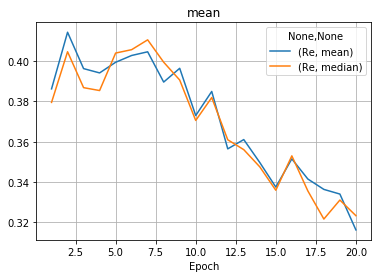

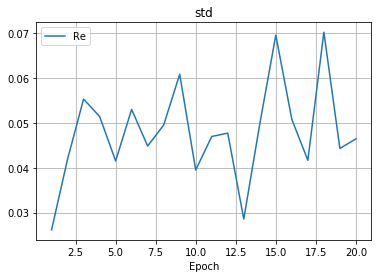

In [22]:
log = pd.read_csv('x', header = None, names = ['Fold', 'Epoch', 'Re'], sep = ' ')
log.groupby('Epoch').agg({'Re': ['mean', 'median']}).plot(grid = True, title = 'mean')
log.groupby('Epoch').agg({'Re': 'std'}).plot(grid = True, title = 'std')
# log.groupby('Epoch').agg({'Re': 'median'}).plot(grid = True, title = 'median')
# log.groupby('Epoch').agg({'Re': 'count'}).plot(grid = True)
log.groupby('Epoch').agg({'Re': 'mean'})
# log[log.Fold == 1]

In [33]:
def lgbm_train(train_part, train_part_label, valide_part, valide_part_label, fold_seed,
        fold = 5, train_weight = None, valide_weight = None, flags = None):
    """
    LGBM Training
    """
    if flags.stacking:
        FEATURE_LIST += ['emb_' + str(i) for i in range(len(CATEGORY_FEATURES) * 5)] + ['k_pred']
    print("-----LGBM training-----")

    d_train = lgb.Dataset(train_part[FEATURE_LIST].values, train_part_label, weight = train_weight, 
            feature_name = FEATURE_LIST, categorical_feature = CATEGORY_FEATURES,)#, init_score = train_part[:, -1])
    d_valide = lgb.Dataset(valide_part[FEATURE_LIST].values, valide_part_label, weight = valide_weight,
            feature_name = FEATURE_LIST, categorical_feature = CATEGORY_FEATURES,)#, init_score = valide_part[:, -1])
    params = {
            'task': 'train',
            'boosting_type': 'gbdt', #'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': 240, #60, #40, # 60,
            'min_sum_hessian_in_leaf': 10,
            'max_depth': 50,#12, #6, # 10,
            'learning_rate': 0.025, # 0.025,
           # 'feature_fraction': 0.5,#0.35, # 0.6
            'verbose': 0,
            'num_boost_round': 500, #361,
            'feature_fraction_seed': fold_seed,
            #'drop_rate': 0.05,
            # 'bagging_fraction': 0.8,
            # 'bagging_freq': 20,
            # 'bagging_seed': fold_seed,
             'early_stopping_round': 1500,
            # 'random_state': 10
            # 'verbose_eval': 20
            #'min_data_in_leaf': 665
        }
    params.update(config.all_params)
    print ("lightgbm params: {0}\n".format(params))

    bst = lgb.train(
                    params ,
                    d_train,
                    verbose_eval = 50,
                    valid_sets = [d_train, d_valide],
                    # feature_name= keras_train.DENSE_FEATURE_LIST,
                    #feval = gini_lgbm
                    #num_boost_round = 1
                    )
    #pred = model_eval(bst, 'l', valide_part)
    #print(pred[:10])
    #print(valide_part_label[:10])
    #print(valide_part[:10, -1])
    # exit(0)
    feature_imp = bst.feature_importance(importance_type = 'gain')
    sort_ind = np.argsort(feature_imp)[::-1]
    print (np.c_[np.array(FEATURE_LIST)[sort_ind], feature_imp[sort_ind]])
    # print (np.array(keras_train.FEATURE_LIST)[np.argsort(feature_imp)])
    # exit(0)
    # cv_result = lgb.cv(params, d_train, nfold=fold) #, feval = gini_lgbm)
    # pd.DataFrame(cv_result).to_csv('cv_result', index = False)
    # exit(0)
    return bst

cand shape:  16
16/16 [==============================] - 0s


Unseen_class: 	0.377448	1195	3166


16/16 [==============================] - 0s


Unseen_class: 	0.263108	833	3166




Unseen_class: 	0.385028	1219	3166


cand shape:  16
16/16 [==============================] - 0s


Unseen_class: 	0.612995	1934	3155


16/16 [==============================] - 0s


Unseen_class: 	0.556894	1757	3155




Unseen_class: 	0.584152	1843	3155


cand shape:  16
16/16 [==============================] - 0s


Unseen_class: 	0.590740	1901	3218


16/16 [==============================] - 0s


Unseen_class: 	0.631137	2031	3218




Unseen_class: 	0.628962	2024	3218


cand shape:  16
16/16 [==============================] - 0s


Unseen_class: 	0.572295	1793	3133


16/16 [==============================] - 0s


Unseen_class: 	0.575806	1804	3133




Unseen_class: 	0.547399	1715	3133


cand shape:  16


KeyboardInterrupt: 

In [98]:
def sub(models, train_data, test_data, class_id_emb_attr, img_model, output_model_path):
    train_id = train_data['class_id'].unique()
    test_img_feature_map = extract_array_from_series(test_data['target'])
    preds = multi_models_vote(models = models, eval_df = test_data, \
            cand_class_id_emb_attr = class_id_emb_attr[~class_id_emb_attr['class_id'].isin(train_id)], \
            img_feature_map = test_img_feature_map)
    sub = pd.DataFrame(preds, index = test_data['img_id'])
    time_label = time.strftime('%Y%m%d_%H%M%S')
    tmp_model_dir = "./model_sub/"
    if not os.path.isdir(tmp_model_dir):
        os.makedirs(tmp_model_dir, exist_ok=True)
    sub_name = tmp_model_dir + "/submit_"+ time_label + ".txt"
    sub.to_csv(sub_name, header = False, sep = '\t')

#     model_name = tmp_model_dir + "imgmodel_" + time_label + ".h5"
#     img_model[0].save(model_name)
#     for i, model in enumerate(models):
#         model_name = tmp_model_dir + "zsmodel_" + str(i) + time_label + ".h5"
#         model[0].save(model_name)

    if not os.path.isdir(output_model_path):
        os.makedirs(output_model_path, exist_ok=True)
    for fileName in os.listdir(tmp_model_dir):
        dst_file = os.path.join(output_model_path, fileName)
        if os.path.exists(dst_file):
            os.remove(dst_file)
        shutil.move(os.path.join(tmp_model_dir, fileName), output_model_path)
        
cand_class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(round2_class_id)]
sub(models = zs_models, train_data = train_data, test_data = test_data, 
        class_id_emb_attr = cand_class_id_emb_attr, img_model = img_model, 
        output_model_path = '../submit/')

cand shape:  45
32/45 [====================>.........] - ETA: 0s

In [20]:
tmp_model_dir = path + "./model_dir/6_12_24_16_ini_64_grow_32_03535/"
# time_label = time.strftime('_%Y_%m_%d_%H_%M_%S', time.gmtime())
# if not os.path.isdir(tmp_model_dir):
#     os.makedirs(tmp_model_dir, exist_ok=True)
# model_name = tmp_model_dir + "model" + time_label + ".h5"
# img_model.model.save(model_name)

In [12]:
pred_class_probas = img_classifi_model.predict(train_image_feature_map, verbose = 1)

38221/38221 [==============================] - 2s 45us/step


In [146]:
train_data['preds'] = list(pred_class_probas)

In [23]:
891 * 80 / 3600

19.8

In [186]:
# np.asarray(list(train_data['img'])).shape
# train_data[train_data['class_id'] == 'ZJL1']
# train_data['class_id'].value_counts().hist()
# train_data.head()
# class_id_emb_attr.iloc[0].name
# resnet50_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3))
img = image.load_img(path + '/DatasetA_train_20180813/train/000c0d617f5b67d116dee15c40d1d47d.jpeg', target_size=(224, 224))
img = image.img_to_array(img)
img = vgg16.preprocess_input(img)
preds = vgg_model.predict(np.expand_dims(img, axis=0))
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])
# imread(path + '/DatasetA_train_20180813/train/000c0d617f5b67d116dee15c40d1d47d.jpeg')
# image.img_to_array(img).shape

Predicted: [('n03598930', 'jigsaw_puzzle', 0.023861792), ('n02095314', 'wire-haired_fox_terrier', 0.022931756), ('n04589890', 'window_screen', 0.021361042)]


In [41]:
# train_data = setA_train_data

img_model = DenseNet(blocks = [6, 12, 24, 16], 
                                cat_max = 205,
                                weight_decay = 1e-4, 
                                kernel_initializer = 'glorot_normal',
                                reduction = 0.5, 
                                init_filters = 128, 
                                growth_rate = 32).model
img_model.load_weights(path + '/model_sub/6_12_24_16_ini64_growth32_inistride2_03621/model_0_2018_09_21_21_10_59.h5')
img_model_flat = Model(input = img_model.input, output = img_model.get_layer(name = 'avg_pool').output)
train_data['target'] = list(img_model_flat.predict(preprocess_img(train_data['img']), verbose = 1))
# train_data['preds'] = list(img_model.predict(train_img, verbose = 1))
# train_data['target'] = list(train_y) #
# with open('../..//Data/model_sub/6_12_24_16_ini128_growth32_inistride1_augdata_05077/model_0_2018_09_24_03_07_15.h5', 'rb') as handle:
#     flat_train_re = pickle.load(handle)
# train_data['target'] = list(flat_train_re)

In [43]:
flat_train_re[0]

array([1.0262023 , 1.0496653 , 0.42650044, ..., 0.09345146, 0.14242867,
       0.        ], dtype=float32)

In [40]:
train_data['target'].iloc[0]

array([2.2266190e+00, 1.6327184e-01, 2.8384233e-01, ..., 4.1941926e-04,
       3.3683911e-02, 7.6473856e-01], dtype=float32)

In [33]:


train_part_img_id = pd.read_csv(path + '/model_sub/6_12_24_16_ini64_growth16_02962/train_part_img_id_0.csv', header = None)
validate_part_img_id = pd.read_csv(path + '/model_sub/6_12_24_16_ini64_growth16_02962/validate_part_img_id_0.csv', header = None)
train_part_img_id = train_part_img_id[0].values
validate_part_img_id = validate_part_img_id[0].values

train_part_df = train_data[train_data['img_id'].isin(train_part_img_id)]
validate_part_df = train_data[train_data['img_id'].isin(validate_part_img_id)]

seen_class = train_part_df.append(validate_part_df).class_id.unique()

train_part_df = train_data[train_data['class_id'].isin(seen_class)]
validate_part_df = train_data[~train_data['class_id'].isin(seen_class)]
# unseen_class_df = train_data[~train_data['class_id'].isin(seen_class)]
unseen_class = validate_part_df.class_id.unique()

# validate_part_df = validate_part_df.append(unseen_class_df)
# train_part_df = train_part_df.append(validate_part_df)
# validate_part_df = unseen_class_df

train_part_data = create_dnn_data(train_part_df)
train_part_target = extract_array_from_series(train_part_df['target'])

validate_part_data = create_dnn_data(validate_part_df)
validate_part_target = extract_array_from_series(validate_part_df['target'])

In [22]:
setB_train_data[setB_train_data.class_id.isin(seen_class)].shape

(39184, 6)

In [33]:
4 / 10.77032961

0.3713906765013109

In [30]:
x = np.random.randint(1, 10, (4,3))
print (x)
print (np.linalg.norm(x, axis = 1))
sklearn.preprocessing.normalize(x, norm='l2')

[[8 6 4]
 [8 7 1]
 [2 2 5]
 [2 1 5]]
[10.77032961 10.67707825  5.74456265  5.47722558]


array([[0.74278135, 0.55708601, 0.37139068],
       [0.74926865, 0.65561007, 0.09365858],
       [0.34815531, 0.34815531, 0.87038828],
       [0.36514837, 0.18257419, 0.91287093]])

In [5]:
import scipy
        
def find_nearest_class(class_id_emb_attr, model, eval_df, cand_feature_map, img_feature_map, 
                       threshold = None, gamma = None, seen_class = None):
#     cand_feature_map = model.predict(create_dnn_data(class_id_emb_attr))
    # img_feature_map = np.repeat(img_feature_map, [cand_feature_map.shape[0]] * img_feature_map.shape[0], axis = 0)
    nearest_class_id = ['ZJL'] * eval_df.shape[0]
#     seen_class_bias = np.zeros(class_id_emb_attr.shape[0])
#     seen_class_bias[class_id_emb_attr.class_id.isin(seen_class)] = gamma
    
#     seen_indice = [category_dict[c] for c in seen_class]
#     preds = np.asarray(list(eval_df['preds']))[:, seen_indice]
    for i in range(img_feature_map.shape[0]):
        if False: #np.amax(preds[i]) > threshold:
            nearest_class_id[i] = seen_class[np.argmax(preds[i])]
        else:
            img = img_feature_map[i]
#             dis = 1 - sklearn.metrics.pairwise.cosine_similarity([img], 
#                                     cand_feature_map).reshape((cand_feature_map.shape[0]))
            dis = np.linalg.norm(img - cand_feature_map, axis = 1)
#             print (dis.shape)
#             if np.amin(dis[class_id_emb_attr.class_id.isin(seen_class)]) > \
#                     gamma * np.amin(dis[~class_id_emb_attr.class_id.isin(seen_class)]):
#                 dis[class_id_emb_attr.class_id.isin(seen_class)] = 200
#             dis += seen_class_bias
#             print(dis)
#             plt.hist(dis)
#             return
            min_ind = np.where(dis == np.amin(dis))[0]
            if len(min_ind) > 1:
                print ('eval img id: ', eval_df.iloc[i]['class_id'], 'has multiple best candidates: ', len(min_ind), 'min val: ', np.amin(dis))
    #         print (i, img, class_id_emb_attr.iloc[min_ind[0]].name)
            nearest_class_id[i] = class_id_emb_attr.iloc[min_ind[0]]['class_id']
#     print (nearest_class_id)
    return np.asarray(nearest_class_id)
        
def calc_accuracy(eval_df, eval_class, preds):
    eval_mask = eval_df.class_id.isin(eval_class)
    eval_num = np.sum(eval_mask)
    right_num = np.sum(preds[eval_mask] == eval_df.class_id[eval_mask])
    return right_num / np.sum(eval_mask), right_num, eval_num
    
def calc_detailed_accuracy(eval_df, preds, seen_class, unseen_class):
    all_re = calc_accuracy(eval_df, eval_df['class_id'].values, preds)
    seen_re = calc_accuracy(eval_df, seen_class, preds)
    unseen_re = calc_accuracy(eval_df, unseen_class, preds)
    print("\nAll_re: \t%.6f\t%.0f\t%.0f" % all_re)
    print("Seen_re: \t%.6f\t%.0f\t%.0f" % seen_re)
    print("Unseen_re: \t%.6f\t%.0f\t%.0f" % unseen_re)

def model_eval(model, model_type, eval_df, cand_class_id_emb_attr, img_feature_map, seen_class = None, unseen_class = None):
    if model_type == 'DEM':
        zs_model = Model(inputs = model.inputs[:2], outputs = model.outputs[0])
        cand_feature_map = zs_model.predict(create_dnn_data(cand_class_id_emb_attr))
    elif model_type == 'GCN':
        zs_model = Model(inputs = model.inputs[2:], outputs = model.outputs[0])
        cand_class_to_id = [class_to_id[c] for c in cand_class_id_emb_attr.class_id.values]
        cand_feature_map = zs_model.predict(None, steps = 1)[cand_class_to_id]
    preds = find_nearest_class(cand_class_id_emb_attr, zs_model, eval_df, cand_feature_map, 
                               img_feature_map)
    if 'class_id' in eval_df.columns:
        calc_detailed_accuracy(eval_df, preds, seen_class, unseen_class)
    return preds

def models_eval(models, eval_df, cand_class_id_emb_attr, img_feature_map, 
                seen_class = None, unseen_class = None):
    preds = []
    for model, model_type in models:
        pred = model_eval(model, model_type, eval_df, cand_class_id_emb_attr, img_feature_map, 
                          seen_class, unseen_class)
        preds.append(pred)
    return preds
        
def multi_models_vote(models, eval_df = None, cand_class_id_emb_attr = None, img_feature_map = None, 
                      seen_class = None, unseen_class = None):
    preds = models_eval(models, eval_df, cand_class_id_emb_attr, img_feature_map, 
                seen_class, unseen_class)
    preds = np.asarray(preds).T
    print (preds)
    vote_preds = []
    for single_img_vote in preds:
        uniq_val, counts = np.unique(single_img_vote, return_counts = True)
        vote_preds.append(uniq_val[np.argmax(counts)])
    vote_preds = np.asarray(vote_preds)
    print (vote_preds)
    if 'class_id' in eval_df.columns: 
        calc_detailed_accuracy(eval_df, vote_preds, seen_class, unseen_class)
    return vote_preds
    
class AccuracyEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, batch_interval = 1000000, verbose = 2, \
            scores = [], class_id_emb_attr = None, eval_df = None, threshold = None, \
                 seen_class = None, unseen_class = None, gamma = None, model_type = None):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        # print("y_val shape:{0}".format(self.y_val.shape))
        self.batch_interval = batch_interval
        self.verbose = verbose
        self.scores = scores
        self.class_id_emb_attr = class_id_emb_attr
        self.eval_df = eval_df
        self.threshold = threshold
        self.seen_class = seen_class
        self.unseen_class = unseen_class
        self.gamma = gamma
        self.model_type = model_type
#         seen_indice = [category_dict[c] for c in seen_class]
#         self.preds = np.asarray(list(eval_df['preds']))[:, seen_indice]
#         self.img_feature_map = self.y_val
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            model_eval(self.model, self.model_type, self.eval_df, self.class_id_emb_attr, 
                seen_class = self.seen_class, unseen_class = self.unseen_class, img_feature_map = self.y_val)
    
    def on_batch_end(self, batch, logs={}):
        return
        if(self.verbose >= 2) and (batch % self.batch_interval == 0):
            # y_pred = self.model.predict(self.X_val, verbose=0)
            # loss = metrics.log_loss(self.y_val, y_pred)
            print("Hi! on_batch_end() , batch=",batch,",logs:",logs)
            # print("Valide size=",y_pred.shape[0], "  Valide loss=",loss)

def full_connect_layer(input, hidden_dim, activation, resnet = False, adj_graphs = None, 
                       drop_out_ratio = None, kernel_initializer = 'he_normal'):
    full_connect = input
    for i, hn in enumerate(hidden_dim):
        fc_in = full_connect
        if drop_out_ratio is not None:
            full_connect = Dropout(drop_out_ratio)(full_connect)
        full_connect = BatchNormalization(epsilon=1.001e-5)(full_connect)
        # full_connect = Dense(hn, kernel_regularizer = l2(0.001), activity_regularizer = l1(0.001))(full_connect)
#         full_connect = Concatenate()([Dense(hn, kernel_initializer='lecun_uniform', activation = 'relu')(full_connect), 
#             Dense(hn, kernel_initializer='lecun_uniform', activation = 'sigmoid')(full_connect)])
        full_connect = Dense(hn, kernel_initializer=kernel_initializer, kernel_regularizer = l2(1e-4), activation = activation)(full_connect)
#         full_connect = LeakyReLU(alpha=0.02)(full_connect)
        # full_connect = self.act_blend(full_connect)
        # if self.full_connect_dropout > 0:
#             full_connect = Dropout(self.full_connect_dropout)(full_connect) #Dropout(self.full_connect_dropout)(full_connect)
        if adj_graphs is not None:
            full_connect = Lambda(lambda x: K.dot(x[1], x[0]), \
                                  name = 'rela_' + str(i))([full_connect, adj_graphs])
        if resnet:
            full_connect = Concatenate()([fc_in, full_connect])
    return full_connect

def extract_array_from_series(s):
    return np.asarray(list(s))

def create_dnn_data(df):
    # return [extract_array_from_series(df['attr']), extract_array_from_series(df['emb'])[:, :]]
    return [extract_array_from_series(df['attr']), extract_array_from_series(df['emb'])[:, :]]

In [84]:
print ('SVD...')
svd = decomposition.TruncatedSVD(n_components=10, n_iter=50, random_state=12)
svd_features = svd.fit_transform(extract_array_from_series(class_id_emb_attr['attr']))
class_id_emb_attr['svd_attr'] = list(svd_features)
train_data = train_data.merge(class_id_emb_attr[['class_id', 'svd_attr']], how = 'left', on = 'class_id')

SVD...


In [86]:
train_data.shape

(87249, 10)

In [22]:
def create_dnn(kernel_initializer = 'he_normal', img_flat_len = 1024):
    alpha = 0.03
    img_flat_len = img_flat_len
    attr_input = Input(shape = (30,), name = 'attr')
    word_emb = Input(shape = (600,), name = 'wv')
    imag_classifier = Input(shape = (img_flat_len,), name = 'img')

    attr_dense = Dense(300, use_bias = False, kernel_initializer=kernel_initializer, 
                       kernel_regularizer = l2(1e-4))(attr_input)
#     attr_dense = Dense(512)(attr_dense)
#     attr_dense = LeakyReLU(alpha=alpha)(attr_dense)
#     attr_dense = Dense(256)(attr_dense)
#     attr_dense = LeakyReLU(alpha=alpha)(attr_dense)
#     attr_dense = Dense(300, activation="relu")(attr_dense)
    # attr_dense = Dense(512, activation="relu")(attr_dense)
    word_emb_dense = Dense(300, use_bias = False, kernel_initializer=kernel_initializer, 
                           kernel_regularizer = l2(1e-4))(word_emb)

    attr_word_emb = Concatenate()([word_emb, attr_dense])
#     attr_word_emb = word_emb #Add()([word_emb_dense, attr_dense])
    attr_word_emb_dense = full_connect_layer(attr_word_emb, hidden_dim = [int(img_flat_len * 1.5), 
#                                                                           int(img_flat_len * 1.25), 
#                                                                           int(img_flat_len * 1.125),
#                                                                           int(img_flat_len * 0.5)
                                                                         ], \
                                             activation = 'relu', resnet = False, drop_out_ratio = 0.2)
    attr_word_emb_dense = full_connect_layer(attr_word_emb_dense, hidden_dim = [img_flat_len], 
                                             activation = 'relu')

    mse_loss = K.mean(keras.losses.mean_squared_error(imag_classifier, attr_word_emb_dense))
    
    model = Model([attr_input, word_emb, imag_classifier], outputs = attr_word_emb_dense) #, vgg_output])
    model.add_loss(mse_loss)
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4), loss=None)
#     model.summary()
    return model

kf = KFold(n_splits=5, shuffle=True, random_state = 100)
num_fold = 0
zs_model_list = []
classes = train_data.class_id.unique()

for train_index, test_index in kf.split(classes):
    seen_class = classes[train_index]
    unseen_class = classes[test_index]
    
    train_part_df = train_data[train_data.class_id.isin(seen_class)]
    validate_part_df = train_data[train_data.class_id.isin(unseen_class)]
    
    train_part_data = create_dnn_data(train_part_df)
    validate_part_data = create_dnn_data(validate_part_df)
    
    train_part_target = extract_array_from_series(train_part_df['target']) #sklearn.preprocessing.normalize(extract_array_from_series(train_part_df['target']), norm='l2')
    validate_part_target = extract_array_from_series(validate_part_df['target']) #sklearn.preprocessing.normalize(extract_array_from_series(validate_part_df['target']), norm='l2')

#     print ('Train Validation Classes: ', train_part_df.class_id.unique().shape[0], 
#            validate_part_df.class_id.unique().shape[0])
    print ('Seen unseen Classes: ', seen_class.shape[0], unseen_class.shape[0])

    callbacks = [
            EarlyStopping(monitor='val_loss', patience=1, verbose=0),
            AccuracyEvaluation(validation_data=(validate_part_data,  validate_part_target), interval=1, \
    #                         class_id_emb_attr = class_id_emb_attr, \
                               eval_df = validate_part_df, threshold= 0.3, \
                              seen_class = seen_class, unseen_class = unseen_class, \
                class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(unseen_class)], \
                              gamma = 0.8, model_type = 'DEM')
            ]
#     for i in range(5):
    zs_model = create_dnn(kernel_initializer = 'he_normal', img_flat_len = 1024)
    if num_fold == 0:
        print (zs_model.summary())
    zs_model.fit(train_part_data + [train_part_target],  validation_data = (validate_part_data + [validate_part_target], None),
                  epochs=50, batch_size = 128, shuffle=True, verbose = 1, callbacks=callbacks)
    zs_model_list.append((zs_model, 'DEM'))
    num_fold += 1

Seen unseen Classes:  164 41


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Output "dense_140" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_140" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attr (InputLayer)               (None, 30)           0                                            
__________________________________________________________________________________________________
wv (InputLayer)                 (None, 600)          0                                            
__________________________________________________________________________________________________
dense_137 (Dense)               (None, 300)          9000        attr[0][0]                       
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 900)          0           wv[0][0]                         
                                                                 dense_137[0][0]                  
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars


70408/70408 [==============================] - 31s 436us/step - loss: 0.3235 - val_loss: 0.3294

All_re: 	0.219999	3705	16841
Seen_re: 	nan	0	0
Unseen_re: 	0.219999	3705	16841
Epoch 3/50
70408/70408 [==============================] - 28s 394us/step - loss: 0.2883 - val_loss: 0.3257

All_re: 	0.207945	3502	16841
Seen_re: 	nan	0	0
Unseen_re: 	0.207945	3502	16841
Epoch 4/50
70408/70408 [==============================] - 29s 418us/step - loss: 0.2808 - val_loss: 0.3216

All_re: 	0.222315	3744	16841
Seen_re: 	nan	0	0
Unseen_re: 	0.222315	3744	16841
Epoch 5/50
70408/70408 [==============================] - 28s 402us/step - loss: 0.2787 - val_loss: 0.3213

All_re: 	0.235972	3974	16841
Seen_re: 	nan	0	0
Unseen_re: 	0.235972	3974	16841
Epoch 6/50
70408/70408 [==============================] - 32s 449us/step - loss: 0.2776 - val_loss: 0.3168

All_re: 	0.238525	4017	16841
Seen_re: 	nan	0	0
Unseen_re: 	0.238525	4017	16841
Epoch 7/50
70408/70408 [==============================] - 28s 399us/step - l

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Output "dense_144" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_144" during training.


Train on 71411 samples, validate on 15838 samples
Epoch 1/50
71411/71411 [==============================] - 106s 1ms/step - loss: 0.5631 - val_loss: 0.4024

All_re: 	0.194090	3074	15838
Seen_re: 	nan	0	0
Unseen_re: 	0.194090	3074	15838
Epoch 2/50
71411/71411 [==============================] - 28s 398us/step - loss: 0.3217 - val_loss: 0.3223

All_re: 	0.224081	3549	15838
Seen_re: 	nan	0	0
Unseen_re: 	0.224081	3549	15838
Epoch 3/50
71411/71411 [==============================] - 29s 402us/step - loss: 0.2867 - val_loss: 0.3117

All_re: 	0.208675	3305	15838
Seen_re: 	nan	0	0
Unseen_re: 	0.208675	3305	15838
Epoch 4/50
71411/71411 [==============================] - 29s 401us/step - loss: 0.2788 - val_loss: 0.3085

All_re: 	0.203687	3226	15838
Seen_re: 	nan	0	0
Unseen_re: 	0.203687	3226	15838
Epoch 5/50
71411/71411 [==============================] - 28s 393us/step - loss: 0.2757 - val_loss: 0.3052

All_re: 	0.207791	3291	15838
Seen_re: 	nan	0	0
Unseen_re: 	0.207791	3291	15838
Epoch 6/50
71411

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Output "dense_148" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_148" during training.


Train on 69141 samples, validate on 18108 samples
Epoch 1/50
69141/69141 [==============================] - 107s 2ms/step - loss: 0.5679 - val_loss: 0.4168

All_re: 	0.197095	3569	18108
Seen_re: 	nan	0	0
Unseen_re: 	0.197095	3569	18108
Epoch 2/50
69141/69141 [==============================] - 30s 439us/step - loss: 0.3233 - val_loss: 0.3322

All_re: 	0.204385	3701	18108
Seen_re: 	nan	0	0
Unseen_re: 	0.204385	3701	18108
Epoch 3/50
69141/69141 [==============================] - 30s 438us/step - loss: 0.2866 - val_loss: 0.3208

All_re: 	0.193837	3510	18108
Seen_re: 	nan	0	0
Unseen_re: 	0.193837	3510	18108
Epoch 4/50
69141/69141 [==============================] - 30s 436us/step - loss: 0.2784 - val_loss: 0.3116

All_re: 	0.206980	3748	18108
Seen_re: 	nan	0	0
Unseen_re: 	0.206980	3748	18108
Epoch 5/50
69141/69141 [==============================] - 30s 433us/step - loss: 0.2749 - val_loss: 0.3123

All_re: 	0.200961	3639	18108
Seen_re: 	nan	0	0
Unseen_re: 	0.200961	3639	18108
Seen unseen Clas

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Output "dense_152" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_152" during training.


Train on 69739 samples, validate on 17510 samples
Epoch 1/50
69739/69739 [==============================] - 108s 2ms/step - loss: 0.5657 - val_loss: 0.4218

All_re: 	0.141005	2469	17510
Seen_re: 	nan	0	0
Unseen_re: 	0.141005	2469	17510
Epoch 2/50
69739/69739 [==============================] - 30s 434us/step - loss: 0.3225 - val_loss: 0.3367

All_re: 	0.165677	2901	17510
Seen_re: 	nan	0	0
Unseen_re: 	0.165677	2901	17510
Epoch 3/50
69739/69739 [==============================] - 30s 430us/step - loss: 0.2867 - val_loss: 0.3231

All_re: 	0.139406	2441	17510
Seen_re: 	nan	0	0
Unseen_re: 	0.139406	2441	17510
Epoch 4/50
69739/69739 [==============================] - 30s 425us/step - loss: 0.2796 - val_loss: 0.3168

All_re: 	0.153113	2681	17510
Seen_re: 	nan	0	0
Unseen_re: 	0.153113	2681	17510
Epoch 5/50
69739/69739 [==============================] - 29s 419us/step - loss: 0.2770 - val_loss: 0.3163

All_re: 	0.141576	2479	17510
Seen_re: 	nan	0	0
Unseen_re: 	0.141576	2479	17510
Epoch 6/50
69739

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Output "dense_156" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_156" during training.


Train on 68297 samples, validate on 18952 samples
Epoch 1/50
68297/68297 [==============================] - 97s 1ms/step - loss: 0.5718 - val_loss: 0.4250

All_re: 	0.190903	3618	18952
Seen_re: 	nan	0	0
Unseen_re: 	0.190903	3618	18952
Epoch 2/50
68297/68297 [==============================] - 30s 441us/step - loss: 0.3240 - val_loss: 0.3366

All_re: 	0.209529	3971	18952
Seen_re: 	nan	0	0
Unseen_re: 	0.209529	3971	18952
Epoch 3/50
68297/68297 [==============================] - 30s 433us/step - loss: 0.2860 - val_loss: 0.3216

All_re: 	0.201192	3813	18952
Seen_re: 	nan	0	0
Unseen_re: 	0.201192	3813	18952
Epoch 4/50
68297/68297 [==============================] - 29s 432us/step - loss: 0.2777 - val_loss: 0.3179

All_re: 	0.212854	4034	18952
Seen_re: 	nan	0	0
Unseen_re: 	0.212854	4034	18952
Epoch 5/50
68297/68297 [==============================] - 29s 430us/step - loss: 0.2744 - val_loss: 0.3180

All_re: 	0.206205	3908	18952
Seen_re: 	nan	0	0
Unseen_re: 	0.206205	3908	18952


In [7]:
for i, model in enumerate(zs_model_list):
    model_name = path + '/model_sub/zs_model_' + str(i) + "_05011.txt"
    zs_model_list[i][0].save(model_name)

In [15]:
multi_models_vote(models = zs_model_list, eval_df = validate_part_df, \
            cand_class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(unseen_class)], \
            img_feature_map = validate_part_target, seen_class = seen_class, unseen_class = unseen_class)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars



All_re: 	0.213811	3570	16697
Seen_re: 	nan	0	0
Unseen_re: 	0.213811	3570	16697

All_re: 	0.227226	3794	16697
Seen_re: 	nan	0	0
Unseen_re: 	0.227226	3794	16697

All_re: 	0.235911	3939	16697
Seen_re: 	nan	0	0
Unseen_re: 	0.235911	3939	16697

All_re: 	0.216566	3616	16697
Seen_re: 	nan	0	0
Unseen_re: 	0.216566	3616	16697

All_re: 	0.070492	1177	16697
Seen_re: 	nan	0	0
Unseen_re: 	0.070492	1177	16697
[['ZJL200' 'ZJL200' 'ZJL200' 'ZJL19' 'ZJL101']
 ['ZJL4' 'ZJL100' 'ZJL41' 'ZJL4' 'ZJL101']
 ['ZJL192' 'ZJL192' 'ZJL192' 'ZJL192' 'ZJL101']
 ...
 ['ZJL261' 'ZJL102' 'ZJL254' 'ZJL254' 'ZJL261']
 ['ZJL254' 'ZJL254' 'ZJL261' 'ZJL254' 'ZJL137']
 ['ZJL261' 'ZJL261' 'ZJL261' 'ZJL254' 'ZJL261']]
['ZJL200' 'ZJL4' 'ZJL192' ... 'ZJL254' 'ZJL254' 'ZJL261']

All_re: 	0.234533	3916	16697
Seen_re: 	nan	0	0
Unseen_re: 	0.234533	3916	16697


array(['ZJL200', 'ZJL4', 'ZJL192', ..., 'ZJL254', 'ZJL254', 'ZJL261'],
      dtype='<U6')

In [54]:
x = np.random.randint(1, 10, (4, 3))
x

array([[8, 5, 9],
       [8, 7, 7],
       [1, 1, 7],
       [7, 1, 9]])

In [99]:
uniq_val, counts = np.unique(x, return_counts = True)
print (uniq_val, counts)
# uniq_val[np.argmax(counts)]
np.argmin(counts)

[1 5 7 8 9] [3 1 4 2 2]


1

In [39]:
attr = np.array(list(class_id_emb_attr['attr']))
# adj_graph = scipy.eye(attr.shape[0]) #1 - sklearn.metrics.pairwise.pairwise_distances(attr, metric = 'cosine')
adj_graph = 1 - sklearn.metrics.pairwise.pairwise_distances(
    np.array(list(class_id_emb_attr['emb'])), metric = 'cosine')
# th = 0.99999
# adj_graph[adj_graph > th] = 1
# adj_graph[adj_graph <= th] = 0
# adj_graph = adj_graph / np.linalg.norm(adj_graph)
# adj_graph = adj_graph[:, np.argsort(adj_graph)[:]]
# adj_graph[1]

In [41]:
class_ids = class_id_emb_attr.class_id.values
class_to_id = dict([(c, i) for i, c in enumerate(class_ids)])
# class_to_id

In [35]:
BATCH_SIZE = 32

# adj_graph = 1 - sklearn.metrics.pairwise.pairwise_distances(
#     np.array(list(class_id_emb_attr['emb']))[:, :300], metric = 'cosine')

def create_gcn():
    alpha = 0.03
    img_flat_len = 1032
    attr_input = Input(tensor=tf.constant(np.array(list(class_id_emb_attr['attr']), dtype = 'float32')))
    all_word_emb = Input(tensor=tf.constant(np.array(list(class_id_emb_attr['emb']))[:, :300], dtype = 'float32')) #Input(shape = (230, 300,), name = 'wv')
    class_index = Input(shape = (1, ), name = 'class_index', dtype = 'int32')
    adj_graphs = Input(tensor=tf.constant(adj_graph, dtype = 'float32')) #Input(shape = (230, 230,), name = 'adj_graph')
    imag_classifier = Input(shape = (img_flat_len,), name = 'img')
    
    attr_dense = Dense(300, use_bias = False, kernel_initializer='he_normal', 
                    kernel_regularizer = l2(1e-4))(attr_input)
    attr_word_emb = Concatenate()([all_word_emb, attr_dense])
#     x = Lambda(lambda xx: all_word_emb)(class_index)
#     x = Dense(516, kernel_initializer='he_normal', kernel_regularizer = l2(1e-4), 
#               activation = 'relu', name = 'conv')(all_word_emb)
#     all_classifier = Lambda(lambda x: K.dot(x[1], x[0]), name = 'rela')([x, adj_graphs])
    all_classifier = full_connect_layer(attr_word_emb, hidden_dim = [int(img_flat_len * 1.5), 
                                                                    int(img_flat_len * 1.25 ),
                                                                    img_flat_len], 
                                activation = 'relu', adj_graphs = adj_graphs)
    x = tf.gather_nd(all_classifier, class_index)

    mse_loss = K.mean(keras.losses.mean_squared_error(imag_classifier, x))
    
    model = Model([class_index, imag_classifier, attr_input, all_word_emb, adj_graphs], outputs = [all_classifier]) #, vgg_output])
    model.add_loss(mse_loss)
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss=None)
#     model.summary()
    return model

kf = KFold(n_splits=5, shuffle=True, random_state = 1)
num_fold = 0
zs_model_list = []
classes = train_data.class_id.unique()
class_ids = class_id_emb_attr.class_id.values
class_to_id = dict([(c, i) for i, c in enumerate(class_ids)])

for train_index, test_index in kf.split(classes):
#     print (train_index)
    seen_class = classes[train_index]
    unseen_class = classes[test_index]
    
    train_part_df = train_data[train_data.class_id.isin(seen_class)]
    validate_part_df = train_data[train_data.class_id.isin(unseen_class)]
    
    train_part_data = np.array([class_to_id[c] for c in train_part_df['class_id'].values]).astype('int32')
    validate_part_data = np.array([class_to_id[c] for c in validate_part_df['class_id'].values]).astype('int32')

    train_part_target = extract_array_from_series(train_part_df['target'])
    validate_part_target = extract_array_from_series(validate_part_df['target'])

#     print ('Train Validation Classes: ', train_part_df.class_id.unique().shape[0], 
#            validate_part_df.class_id.unique().shape[0])
    print ('Seen unseen Classes: ', seen_class.shape[0], unseen_class.shape[0])

    callbacks = [
            EarlyStopping(monitor='val_loss', patience=50, verbose=0),
            AccuracyEvaluation(validation_data=(validate_part_data,  validate_part_target), interval=1, \
    #                         class_id_emb_attr = class_id_emb_attr, \
                               eval_df = validate_part_df, threshold= 0.3, \
                              seen_class = seen_class, unseen_class = unseen_class, \
                class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(unseen_class)], \
                              gamma = 0.8, model_type = 'GCN')
            ]
    zs_model = create_gcn()
    if num_fold == 0:
        print (zs_model.summary())
    zs_model.fit([train_part_data, train_part_target],  
                 validation_data = ([validate_part_data, validate_part_target], None),
                  epochs=25, batch_size = 32, shuffle=True, verbose = 1, callbacks=callbacks)
    zs_model_list.append((zs_model, 'GCN'))
    num_fold += 1

Seen unseen Classes:  164 41
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_32 (InputLayer)            (285, 30)             0                                            
____________________________________________________________________________________________________
input_33 (InputLayer)            (285, 300)            0                                            
____________________________________________________________________________________________________
dense_84 (Dense)                 (285, 300)            9000        input_32[0][0]                   
____________________________________________________________________________________________________
concatenate_15 (Concatenate)     (285, 600)            0           input_33[0][0]                   
                                                              

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: UserWarning: Output "rela_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "rela_2" during training.


Train on 69913 samples, validate on 17336 samples
Epoch 1/25
69792/69913 [============================>.] - ETA: 0s - loss: 1.7330eval img id:  ZJL263 has multiple best candidates:  2 min val:  18.49614

All_re: 	0.038417	666	17336
Seen_re: 	nan	0	0
Unseen_re: 	0.038417	666	17336
69913/69913 [==============================] - 33s - loss: 1.7317 - val_loss: 1.0597
Epoch 2/25
  416/69913 [..............................] - ETA: 29s - loss: 0.9983

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars


69856/69913 [============================>.] - ETA: 0s - loss: 0.9736
All_re: 	0.068066	1180	17336
Seen_re: 	nan	0	0
Unseen_re: 	0.068066	1180	17336
69913/69913 [==============================] - 32s - loss: 0.9736 - val_loss: 1.0059
Epoch 3/25
69792/69913 [============================>.] - ETA: 0s - loss: 0.8904
All_re: 	0.082603	1432	17336
Seen_re: 	nan	0	0
Unseen_re: 	0.082603	1432	17336
69913/69913 [==============================] - 32s - loss: 0.8903 - val_loss: 0.9059
Epoch 4/25
 9536/69913 [===>..........................] - ETA: 24s - loss: 0.8300

KeyboardInterrupt: 

In [103]:
multi_models_vote(models = zs_model_list, eval_df = validate_part_df, \
            cand_class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(unseen_class)], \
            img_feature_map = validate_part_target, seen_class = seen_class, unseen_class = unseen_class)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars



All_re: 	0.156834	2140	13645
Seen_re: 	nan	0	0
Unseen_re: 	0.156834	2140	13645

All_re: 	0.155148	2117	13645
Seen_re: 	nan	0	0
Unseen_re: 	0.155148	2117	13645

All_re: 	0.151118	2062	13645
Seen_re: 	nan	0	0
Unseen_re: 	0.151118	2062	13645

All_re: 	0.153316	2092	13645
Seen_re: 	nan	0	0
Unseen_re: 	0.153316	2092	13645

All_re: 	0.157640	2151	13645
Seen_re: 	nan	0	0
Unseen_re: 	0.157640	2151	13645
[['ZJL264' 'ZJL264' 'ZJL264' 'ZJL264' 'ZJL264']
 ['ZJL102' 'ZJL102' 'ZJL102' 'ZJL102' 'ZJL102']
 ['ZJL254' 'ZJL276' 'ZJL254' 'ZJL254' 'ZJL254']
 ...
 ['ZJL254' 'ZJL254' 'ZJL276' 'ZJL254' 'ZJL254']
 ['ZJL276' 'ZJL276' 'ZJL276' 'ZJL276' 'ZJL254']
 ['ZJL168' 'ZJL125' 'ZJL50' 'ZJL168' 'ZJL254']]
['ZJL264' 'ZJL102' 'ZJL254' ... 'ZJL254' 'ZJL276' 'ZJL168']

All_re: 	0.166215	2268	13645
Seen_re: 	nan	0	0
Unseen_re: 	0.166215	2268	13645


In [48]:
with open(path + 'model_sub/train_data_2018_09_23_10_32_21.pickle', 'rb') as handle:
    test = pickle.load(handle)

In [50]:
test.head()

,class_id,img_id,img,target,preds
0,ZJL1,a6394b0f513290f4651cc46792e5ac86.jpeg,"[[[20.0, 33.0, 7.0], [19.0, 32.0, 6.0], [22.0,...","[2.2266192, 0.16327204, 0.2838421, 0.2219766, ...","[0.9520665, 4.647786e-09, 7.417136e-08, 3.9506..."
1,ZJL1,2fb89ef2ace869d3eb3bdd3afe184e1c.jpeg,"[[[140.0, 45.0, 51.0], [144.0, 47.0, 54.0], [1...","[0.17702743, 0.55263615, 0.0, 0.030876435, 1.2...","[1.30949e-05, 5.735788e-10, 6.5571693e-12, 5.9..."
2,ZJL1,eda9f3bef2bd8da038f6acbc8355fc25.jpeg,"[[[81.0, 69.0, 21.0], [86.0, 74.0, 26.0], [85....","[0.0, 0.42584094, 0.0, 0.034428038, 0.527664, ...","[0.9993531, 4.2289447e-09, 1.2198088e-07, 3.68..."
3,ZJL1,7d93ef45972154aae150b4f9980a79c0.jpeg,"[[[16.0, 14.0, 15.0], [18.0, 16.0, 17.0], [19....","[0.6332717, 0.23473893, 0.0, 0.779357, 1.38354...","[0.9999671, 4.578459e-10, 6.6002594e-12, 8.168..."
4,ZJL1,fb901b4f9a8e396c1d0155bccc5e5671.jpeg,"[[[120.0, 124.0, 127.0], [89.0, 93.0, 96.0], [...","[0.37087774, 1.1033719, 0.0, 0.23497638, 3.003...","[0.86532485, 3.0740804e-08, 3.727919e-08, 1.21..."


In [23]:
test_data = pd.read_csv(path + '/DatasetA_test_20180813/DatasetA_test/image.txt', header = None, names = ['img_id'])
imag_path = path + '/DatasetA_test_20180813/DatasetA_test/test/'
test_data['img'] = test_data['img_id'].apply(lambda id: read_image(imag_path, id))
# with open(path + 'test_data.pickle', 'rb') as handle:
#     test_data = pickle.load(handle)

In [79]:
# with open(path + 'test_data.pickle', 'wb+') as handle:
#     pickle.dump(test_data, handle)
# test_data.head()
with open(path + '/model_sub/stacking_train_label_2018_09_12_12_10_06.pickle', 'rb') as handle:
    stacking_train_data = pickle.load(handle)
stacking_train_data.head()

0        [0.12423625, 0.1190791, 0.7566846]
1       [1.7260123e-13, 2.1865514e-08, 1.0]
2       [0.2117803, 0.17989996, 0.60831976]
3        [0.2420589, 0.17926142, 0.5786797]
4    [0.041276723, 0.95284086, 0.005882429]
dtype: object

In [24]:
img_model = DenseNet(blocks = [6, 12, 24, 16], 
                                cat_max = 171,
                                weight_decay = 1e-4, 
                                kernel_initializer = 'glorot_normal',
                                reduction = 0.5, 
                                init_filters = 64, 
                                growth_rate = 16).model
img_model.load_weights(path + 'model_sub/6_12_24_16_ini64_growth16_02962/model_0_2018_09_13_08_23_48.h5')
img_model_flat = Model(input = img_model.input, output = img_model.get_layer(name = 'avg_pool').output)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D) (None, 70, 70, 3)     0           input_17[0][0]                   
____________________________________________________________________________________________________
conv1/conv (Conv2D)              (None, 68, 68, 64)    1728        zero_padding2d_3[0][0]           
____________________________________________________________________________________________________
conv1/bn (BatchNormalization)    (None, 68, 68, 64)    256         conv1/conv[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  if __name__ == '__main__':


In [9]:
# test_data = setB_test_data
# # test_img = extract_array_from_series(test_data['img'])
# # test_img = vgg16.preprocess_input(test_img)
# # test_img_feature_map = img_model_flat.predict(test_img, verbose = 1)

# with open(path + '/model_sub/6_12_24_16_ini64_growth32_inistride1_augdata_05010/flat_test_re_2018_09_22_19_24_38.pickle', 'rb') as handle:
#     test_img_feature_map = pickle.load(handle)
train_id = train_data['class_id'].unique()
test_img_feature_map = extract_array_from_series(test_data['target'])
# class_id_emb_attr.reset_index(inplace = True)

In [107]:
zs_partial_model = Model(inputs = zs_model.inputs[2:], outputs = zs_model.outputs[0])
test_class_id_emb_attr = class_id_emb_attr #[~class_id_emb_attr['class_id'].isin(train_id)]
# pred_nearest_class_id = find_nearest_class(test_class_id_emb_attr, zs_partial_model, test_data, test_img_feature_map)

In [10]:
preds_05011 = models_eval(models = zs_model_list, eval_df = test_data, \
            cand_class_id_emb_attr = class_id_emb_attr[~class_id_emb_attr['class_id'].isin(train_id)], \
            img_feature_map = test_img_feature_map)
preds_05011 = np.asarray(preds_05011).T

In [19]:
preds_05077.shape

AttributeError: 'list' object has no attribute 'shape'

In [17]:
with open(path + '/model_sub/6_12_24_16_ini128_growth32_inistride1_augdata_05077/flat_test_re_2018_09_24_03_07_15.pickle', 'rb') as handle:
    flat_test_re = pickle.load(handle)
zs_model_05077_list = []
for i in range(5):
    zs_model = create_dnn(kernel_initializer = 'he_normal', img_flat_len = 1032)
    zs_model_name = path + '/model_sub/6_12_24_16_ini128_growth32_inistride1_augdata_05077/zs_model_' + str(i) +'_2018_09_25_01_01_31.txt'
    zs_model.load_weights(zs_model_name)
    zs_model_05077_list.append((zs_model, 'DEM'))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Output "dense_102" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_102" during training.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Output "dense_108" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_108" during training.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Output "dense_114" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_114" during training.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Output "dense_120" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_120" during training.
/usr/local/lib/p

In [18]:
preds_05077 = models_eval(models = zs_model_05077_list, eval_df = test_data, \
            cand_class_id_emb_attr = class_id_emb_attr[~class_id_emb_attr['class_id'].isin(train_id)], \
            img_feature_map = flat_test_re)
preds_05011 = np.asarray(preds_05011).T
preds = np.c_[preds_05011, preds_05077]
print (preds)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
vote_preds = []
for single_img_vote in preds:
    uniq_val, counts = np.unique(single_img_vote, return_counts = True)
    vote_preds.append(uniq_val[np.argmax(counts)])
vote_preds = np.asarray(vote_preds)
print (vote_preds)

In [97]:
pred_nearest_class_id = multi_models_vote(models = zs_model_list, eval_df = test_data, \
            cand_class_id_emb_attr = class_id_emb_attr[~class_id_emb_attr['class_id'].isin(train_id)], \
            img_feature_map = test_img_feature_map)

[['ZJL272' 'ZJL224' 'ZJL242' 'ZJL243' 'ZJL272']
 ['ZJL243' 'ZJL288' 'ZJL239' 'ZJL243' 'ZJL239']
 ['ZJL255' 'ZJL255' 'ZJL255' 'ZJL255' 'ZJL253']
 ...
 ['ZJL286' 'ZJL259' 'ZJL249' 'ZJL259' 'ZJL287']
 ['ZJL270' 'ZJL253' 'ZJL253' 'ZJL253' 'ZJL253']
 ['ZJL270' 'ZJL288' 'ZJL288' 'ZJL288' 'ZJL253']]
['ZJL272' 'ZJL239' 'ZJL255' ... 'ZJL259' 'ZJL253' 'ZJL288']


In [98]:
time_label = time.strftime('_%Y_%m_%d_%H_%M_%S', time.gmtime())
sub_name = path + '/model_sub/sub' + time_label + '.txt'
sub = pd.DataFrame(pred_nearest_class_id, index = test_data['img_id'])
sub.to_csv(sub_name, header = False, sep = '\t')
# zs_model.save(path + 'zs_model' + time_label + '.h5')

In [28]:
152 * 200 / 3600

8.444444444444445